In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

# 读入

In [14]:
Bus_Stops = pd.read_csv('data/Bus_Stops.csv')
edges_all = pd.read_csv('data/edges_all.csv')
nodes_all = pd.read_csv('data/nodes_all.csv')

# 转换

In [3]:
Bus_Stops['Routes_Ser'] = Bus_Stops['Routes_Ser'].apply(lambda row: len(row.split(',')) if isinstance(row, str) else 0)


In [4]:
Bus_Stops['Routes_Ser'] = Bus_Stops['Routes_Ser'].apply(lambda row: len(row.split(',')) if isinstance(row, str) else 0)
edges_all["lanes"] = pd.to_numeric(edges_all["lanes"], errors="coerce")
edges_all["maxspeed"] = edges_all["maxspeed"].apply(
    lambda x: x.replace("mph", "").strip() if isinstance(x, str) else x
)
# 如果 'maxspeed' 列包含像 ['45 ', '60 '] 这样的列表，取出第一个值
edges_all["maxspeed"] = edges_all["maxspeed"].apply(
    lambda x: eval(x)[0] if isinstance(x, str) and x.startswith("[") else x
)
edges_all["maxspeed"] = pd.to_numeric(edges_all["maxspeed"], errors="coerce")
edges_all["lanes"].fillna(edges_all["lanes"].median(), inplace=True)
edges_all["maxspeed"].fillna(edges_all["maxspeed"].median(), inplace=True)

pos=dict()
for _,row in nodes_all.iterrows():
    pos[row['osmid']]=(row['x'],row['y'])

/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_27560/1801522482.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  edges_all["lanes"].fillna(edges_all["lanes"].median(), inplace=True)
/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_27560/1801522482.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [5]:
alpha, beta, gamma = 0.5, 0.4, 0.5

def calculate_weight(row):
    length_weight = row["length"] / max_length
    aadt_weight = 0
    #aadt_weight = row["AADT 2022"] / max_aadt
    lanes_weight = row["lanes"] / max_lanes
    return alpha * length_weight + beta * aadt_weight + gamma * lanes_weight

max_length = edges_all["length"].max()
#max_aadt = edges_all["AADT 2022"].max()
max_lanes = edges_all["lanes"].max()
for _, row in edges_all.iterrows():
    edges_all.loc[_, "weight"] = calculate_weight(row)

# 地图上的巴士点映射

In [6]:
G = nx.DiGraph()
cnt=0
rng = 0.12
location = (39.299200, -76.609400)


def getdis(x, y):
    return sqrt((x[0] - y[1]) ** 2 + (x[1] - y[0]) ** 2)

for _, row in edges_all.iterrows():
    if row["u"] == row["v"]:
        continue
    if getdis(pos[row["u"]], location) > rng or getdis(pos[row["v"]], location) > rng:
        continue
    cnt += 1
    # if cnt>10000:
    # break
    G.add_edge(
        row["u"],
        row["v"],
        weight=row["weight"],
        length=row["length"],
        lanes=row["lanes"],
        maxspeed=row["maxspeed"],
    )

In [7]:
plt.figure(figsize=(100,100))

print("Drawing nodes")
nx.draw_networkx_nodes(G,pos,node_size=1,node_color='blue',alpha=0.3)

print("Drawing edges")
nx.draw_networkx_edges(G,pos,edge_color='gray',width=3,style='dashed')

print("Drawing Bus_Stops")

top_riders = Bus_Stops[['X', 'Y','stop_name', 'Rider_Tota']].sort_values(by='Rider_Tota', ascending=False).head(100)

plt.title('Bus Traffic Flow Map', fontsize=16)

plt.scatter(Bus_Stops['X'], Bus_Stops['Y'], color='#555555',s = Bus_Stops['Rider_Tota'])

plt.scatter(top_riders['X'], top_riders['Y'], color='red',s = top_riders['Rider_Tota'])

plt.axis('off')
plt.tight_layout()
plt.show()


Drawing nodes
Drawing edges


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x11945bd80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# 热力图

In [ ]:
import folium
from folium.plugins import HeatMap

map_center = [39.2992, -76.6094]  
m = folium.Map(location=map_center, zoom_start=12)

heat_data = [[row['Y'], row['X'], row['Rider_Tota']] for index, row in Bus_Stops.iterrows()]

HeatMap(heat_data).add_to(m)

m.save('baltimore_bus_stop_heatmap.html')


In [18]:
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point

coordinates = Bus_Stops[['X', 'Y']].values

# 设置KDE带宽
bandwidth = 0.01

# 归一化上下车人数
weights = Bus_Stops['Rider_Tota']
weights = (weights - weights.min()) / (weights.max() - weights.min())

# 创建KDE模型并拟合数据
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(coordinates, sample_weight=weights)

# 生成网格数据，用于绘制热力图
x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
xv, yv = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

# 计算每个网格点的密度
log_densities = kde.score_samples(grid_points)
densities = np.exp(log_densities).reshape(xv.shape)



/opt/miniconda3/envs/mcm/lib/python3.8/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


In [19]:
# 设施名称和坐标
facilities = [
    {"name": "Inner Harbor", "x": 39.2847, "y": -76.6122, "category": "Tourist"},
    {"name": "Penn Station", "x": 39.3083, "y": -76.6167, "category": "Transport"},
    {"name": "Port of Baltimore", "x": 39.2904, "y": -76.6122, "category": "Transport"},
    {"name": "Maryland Science Center", "x": 39.2884, "y": -76.6120, "category": "Museum"},
    {"name": "Maryland Zoo", "x": 39.3200, "y": -76.6500, "category": "Zoo"},
    {"name": "Baltimore Museum of Art", "x": 39.3295, "y": -76.6210, "category": "Museum"},
    {"name": "Johns Hopkins Hospital", "x": 39.2966, "y": -76.5947, "category": "Hospital"},
    {"name": "University of Baltimore", "x": 39.3073, "y": -76.6204, "category": "University"},
    {"name": "Baltimore Mall", "x": 39.3054, "y": -76.6200, "category": "Mall"}
] 

# 定义不同类别的颜色
category_colors = {
    "Tourist": "lime",        # 旅游类
    "Transport": "magenta",   # 交通类
    "Museum": "cyan",         # 博物馆类
    "Zoo": "black",             # 动物园类
    "Hospital": "purple",     # 医院类
    "University": "darkorange", # 大学类
    "Mall": "deepskyblue"     # 商场类
}

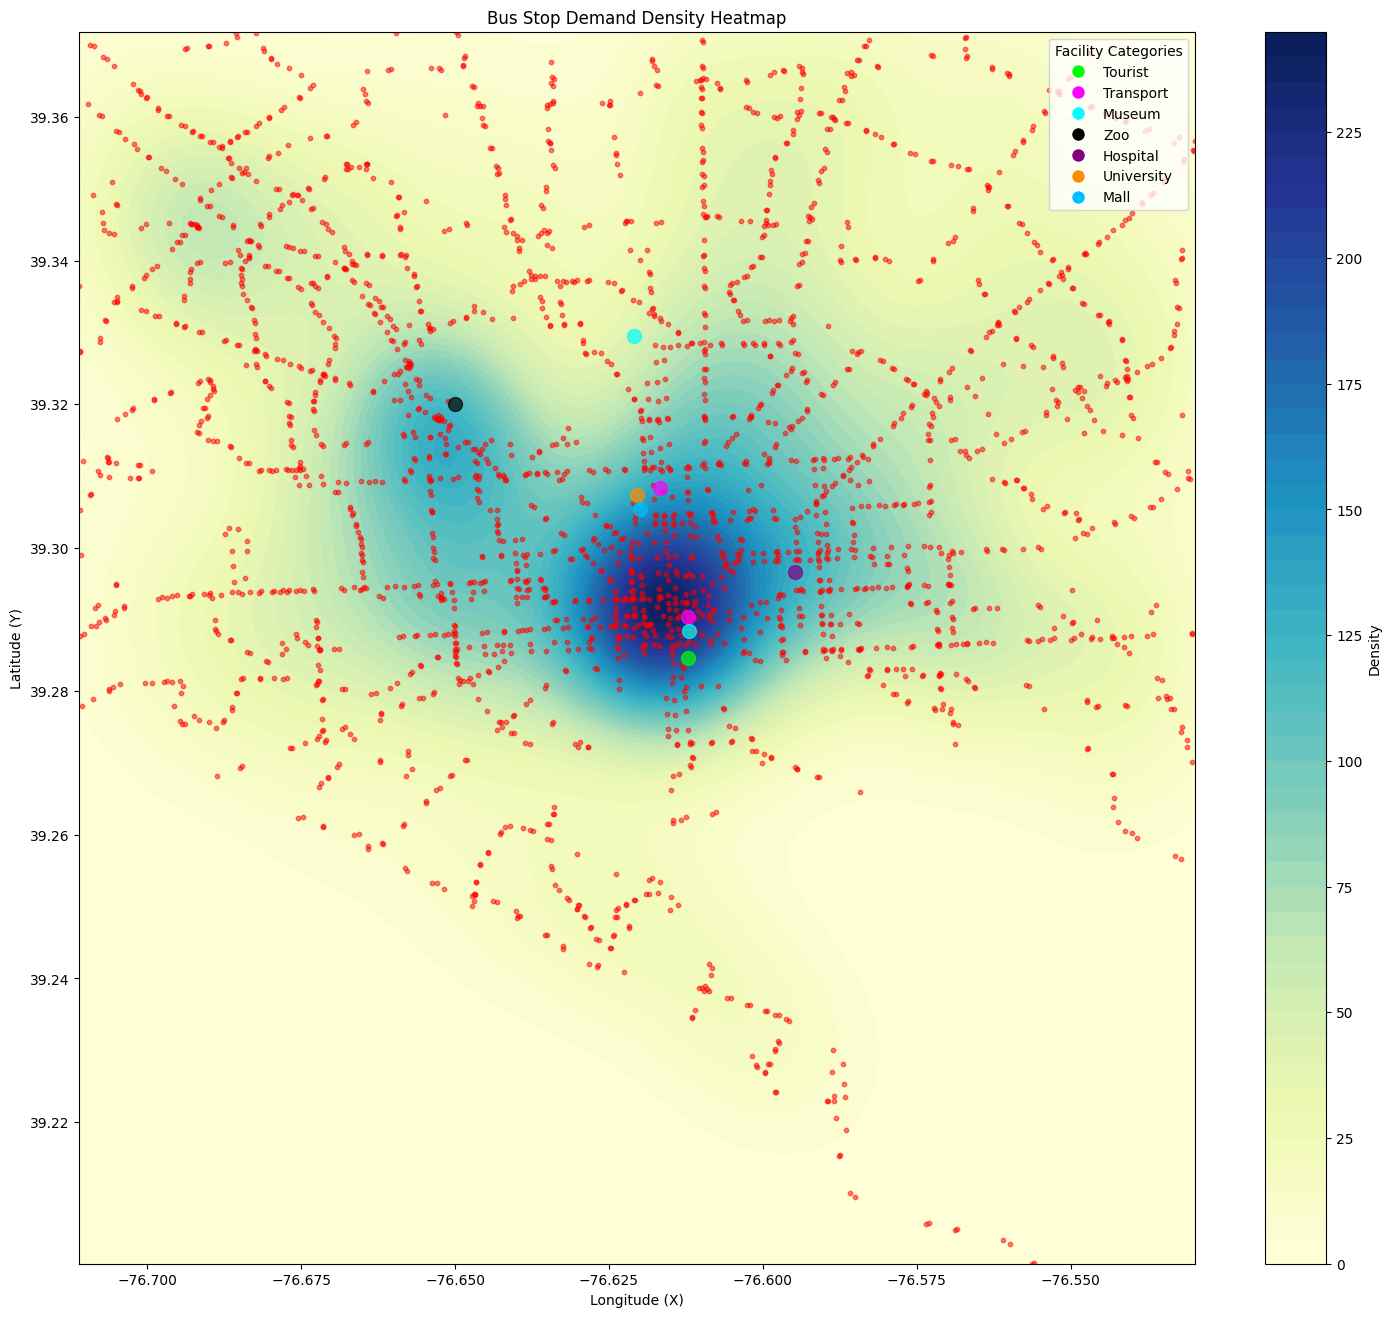

In [20]:
from matplotlib.lines import Line2D
# 绘制热力图
plt.figure(figsize=(18, 16))
plt.contourf(xv, yv, densities, cmap='YlGnBu', levels=50)
plt.colorbar(label='Density')
plt.scatter(Bus_Stops['X'], Bus_Stops['Y'], color='red', s=10, alpha=0.5, label='Bus Stops')

# 添加设施点
for facility in facilities:
    color = category_colors.get(facility["category"], "black")  # 获取颜色
    plt.scatter(facility["y"], facility["x"], color=color, s=100, alpha=0.7)  # 绘制设施点

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Facility Categories", loc='upper right')

plt.title('Bus Stop Demand Density Heatmap')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

In [21]:
print(f"Min density: {densities.min()}")
print(f"Max density: {densities.max()}")

Min density: 1.475712348847318e-11
Max density: 240.88483539864393


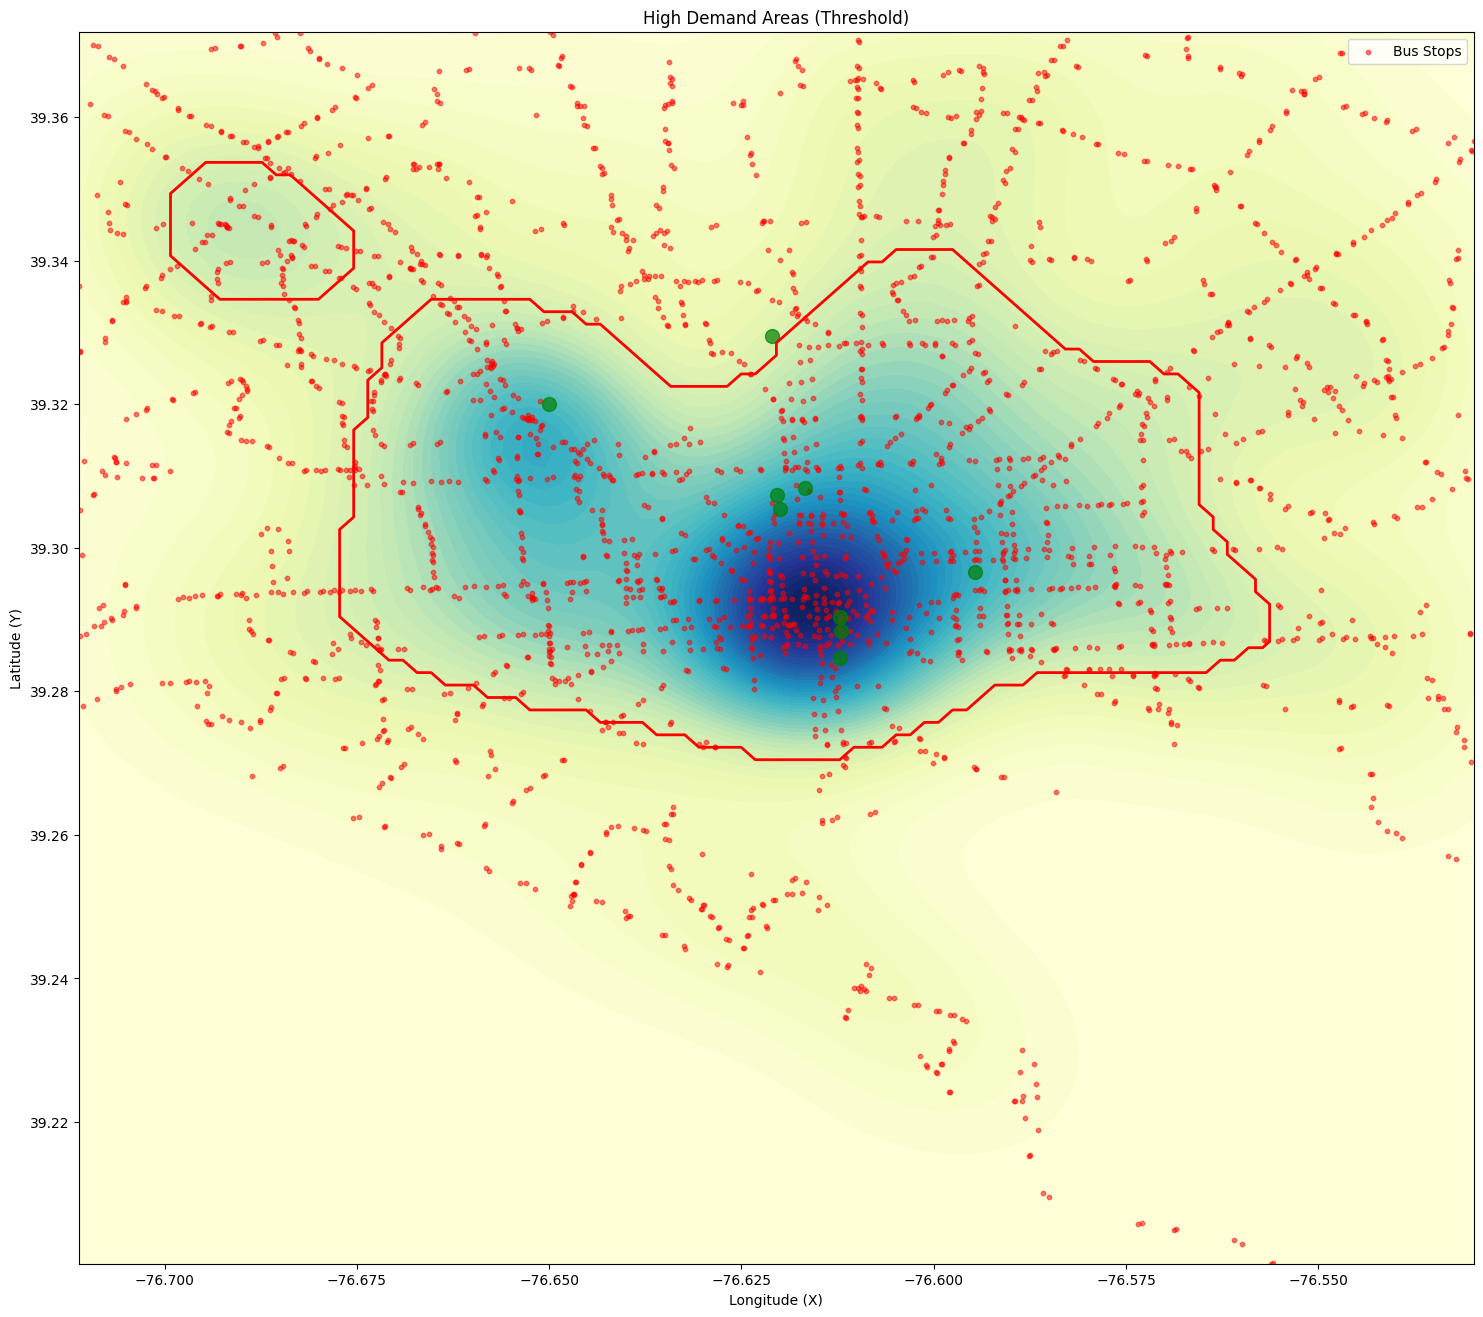

In [22]:
# 根据需求设置一个密度阈值
threshold = densities.max() * 0.2 
high_density_area = densities > threshold

# 绘制高需求区域
plt.figure(figsize=(18, 16))
plt.contourf(xv, yv, densities, cmap='YlGnBu', levels=50)
plt.contour(xv, yv, high_density_area, levels=[0.5], colors='red', linewidths=2)
plt.scatter(Bus_Stops['X'], Bus_Stops['Y'], color='red', s=10, alpha=0.5, label='Bus Stops')

# 添加绿色设施点
for facility in facilities:
    plt.scatter(facility["y"], facility["x"], color='green', s=100, alpha=0.7)

plt.title('High Demand Areas (Threshold)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend()
plt.show()

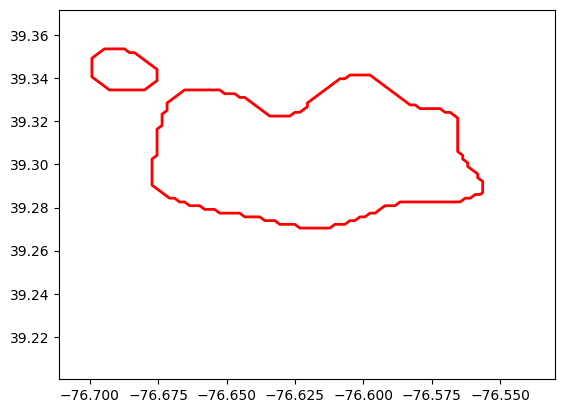

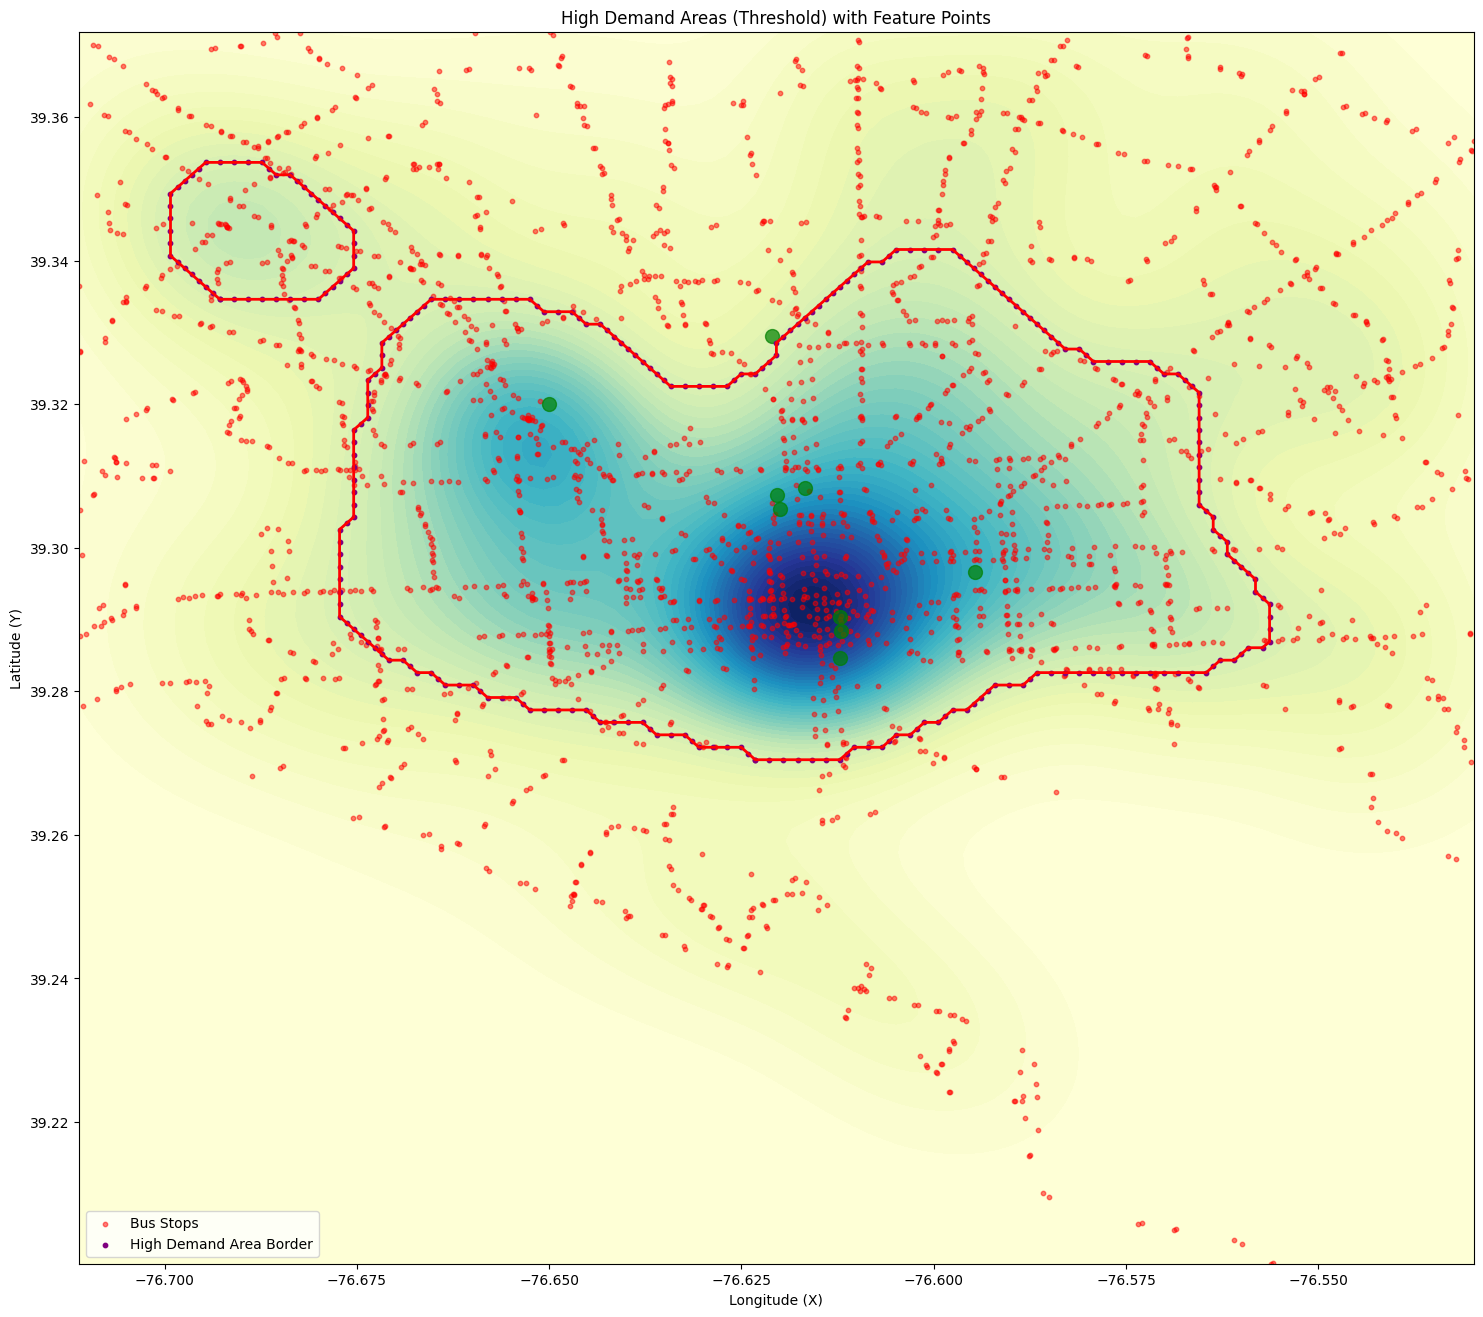

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# 获取高需求区域的轮廓线
contours = plt.contour(xv, yv, high_density_area, levels=[0.5], colors='red', linewidths=2)

# 从轮廓线中提取特征点
contour_points = []
for collection in contours.collections:
    for path in collection.get_paths():
        for point in path.vertices:
            contour_points.append(tuple(point))

# 将提取的点存储为CSV格式
contour_points = np.array(contour_points)

# 转换为 DataFrame，并存储为 CSV 文件
df_contour_points = pd.DataFrame(contour_points, columns=["Longitude", "Latitude"])
df_contour_points.to_csv("high_demand_area.csv", index=False)

# 可视化高需求区域与提取的特征点
plt.figure(figsize=(18, 16))
plt.contourf(xv, yv, densities, cmap='YlGnBu', levels=50)
plt.contour(xv, yv, high_density_area, levels=[0.5], colors='red', linewidths=2)
plt.scatter(Bus_Stops['X'], Bus_Stops['Y'], color='red', s=10, alpha=0.5, label='Bus Stops')

# 添加绿色设施点
for facility in facilities:
    plt.scatter(facility["y"], facility["x"], color='green', s=100, alpha=0.7)

# 添加高需求区域的边界点
plt.scatter(contour_points[:, 0], contour_points[:, 1], color='purple', s=10, label="High Demand Area Border")

plt.title('High Demand Areas (Threshold) with Feature Points')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.legend()
plt.show()


In [15]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


# 高需求区域评分

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import random

# 获取高需求区域的轮廓线
contours = plt.contour(xv, yv, high_density_area, levels=[0.5], colors='red', linewidths=2)

service_radius = 500 #单位：米

# 从轮廓线中提取特征点
contour_points = []
for collection in contours.collections:
    for path in collection.get_paths():
        for point in path.vertices:
            contour_points.append(tuple(point))

# 将提取的点存储为多边形对象
contour_points = np.array(contour_points)
polygon = Polygon(contour_points)

# 生成在多边形内的随机点
def generate_random_points_in_polygon(polygon, N):
    points = []
    while len(points) < N:
        minx, miny, maxx, maxy = polygon.bounds
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# 判断站点是否在 500 米圆内
def is_covered_by_bus_station(random_point, bus_stops, radius=500):
    circle = random_point.buffer(radius / 111000)  # 转换半径为度
    for stop in bus_stops.itertuples():
        stop_location = Point(stop.X, stop.Y)  # 站点坐标
        if circle.contains(stop_location):
            return 1  
    return 0  

# 生成 1000 个随机点
random_points = generate_random_points_in_polygon(polygon, 10000)

covered_count = 0
total_count = len(random_points)

# 遍历所有随机点，计算其覆盖情况
for point in random_points:
    covered_count += is_covered_by_bus_station(point, Bus_Stops)

# 计算交通均匀分布的评分（为 1 的比例）
uniform_distribution = covered_count / total_count
print(f"交通均匀分布的评分：{uniform_distribution:.4f}")

# 输出为 1 和为 0 的点数
print(f"为 1 的点数：{covered_count}/10000")
print(f"为 0 的点数：{total_count - covered_count}/10000")

NameError: name 'xv' is not defined

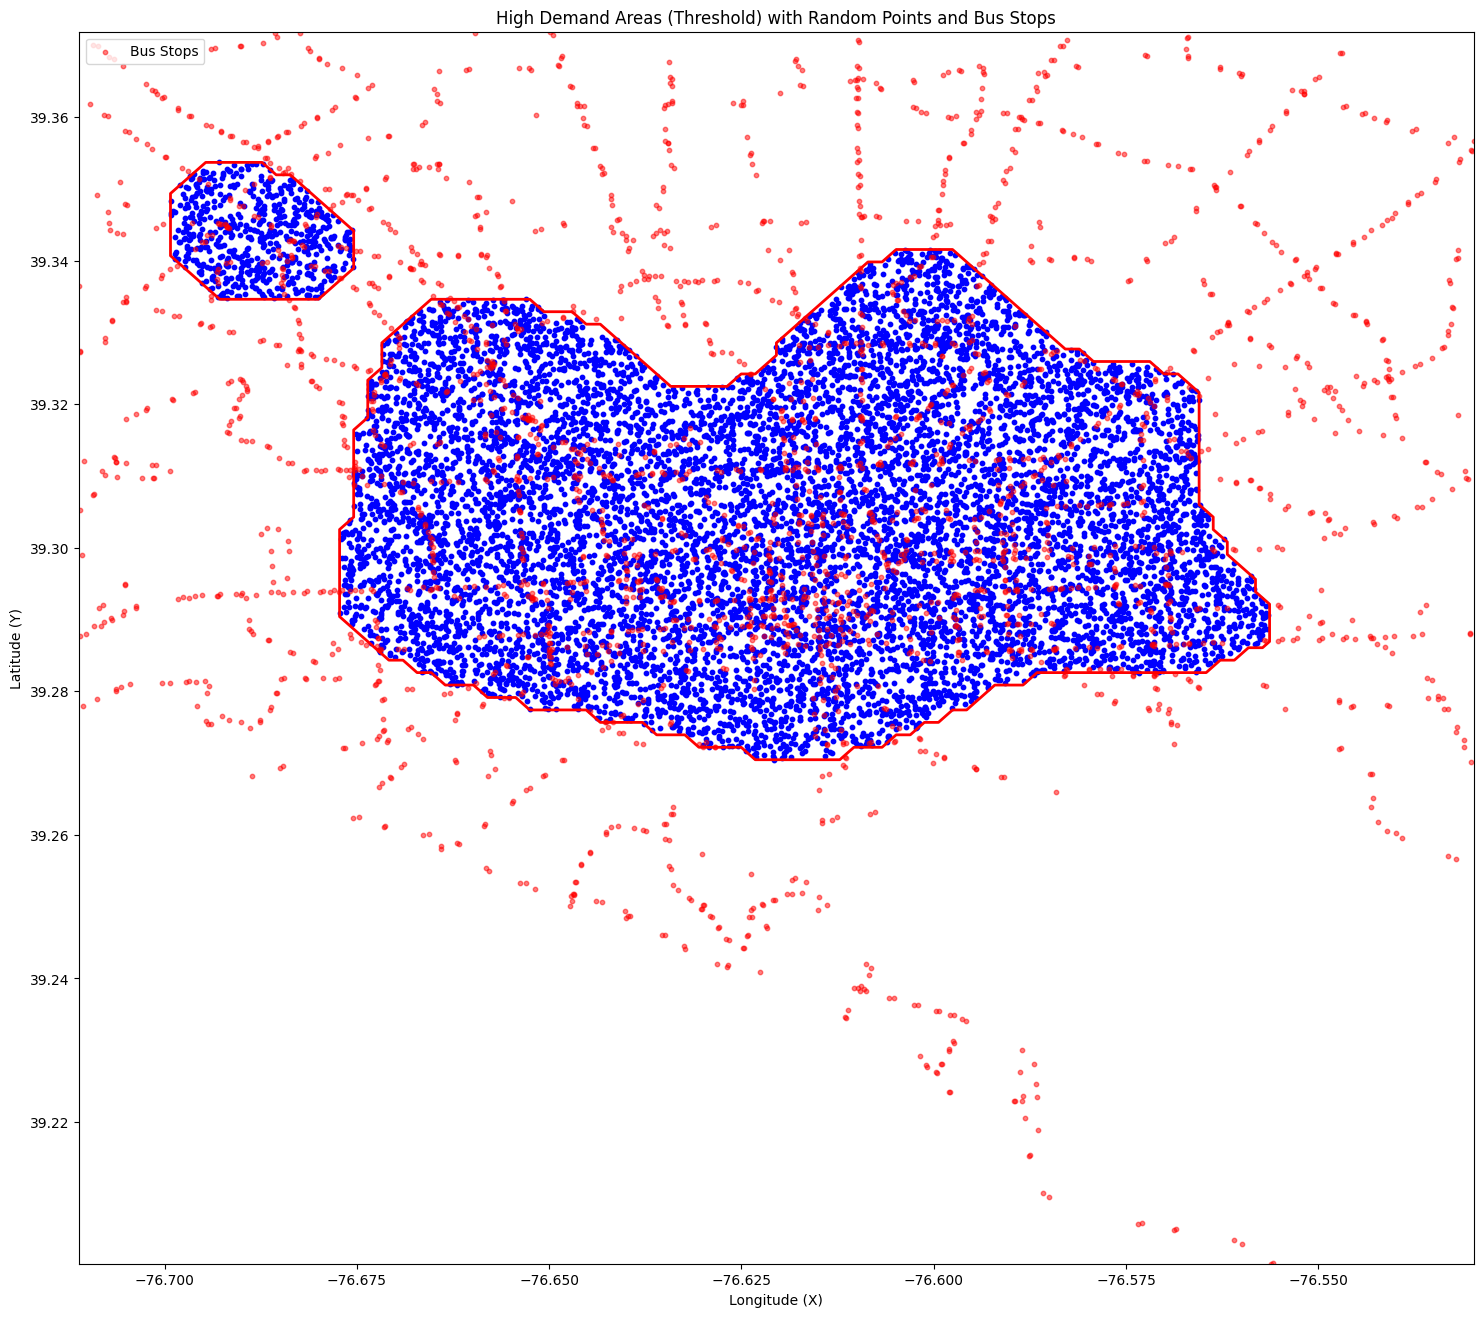

In [26]:
# 可视化高需求区域与生成的随机点
plt.figure(figsize=(18, 16))

# 绘制高需求区域的轮廓线（红色）
plt.contour(xv, yv, high_density_area, levels=[0.5], colors='red', linewidths=2)

# 绘制生成的随机点（蓝色）
for point in random_points:
    plt.scatter(point.x, point.y, color='blue', s=10)

# 绘制巴士站点
plt.scatter(Bus_Stops['X'], Bus_Stops['Y'], color='red', s=10, alpha=0.5, label='Bus Stops')

# 设置图表标题和标签
plt.title('High Demand Areas (Threshold) with Random Points and Bus Stops')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')

# 显示图例
plt.legend(loc='upper left')
plt.show()

# 线路聚类,找线路


In [17]:
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

In [18]:
print(Bus_Stops_row.head())

   Unnamed: 0          X                            stop_name  Rider_On  \
0   39.350945 -76.660393  CYLBURN AVE & GREENSPRING AVE fs wb       201   
1   39.351545 -76.663359       LANIER AVE & SINAI HOSPITAL sb        38   
2   39.352749 -76.664492        LANIER AVE & BELVEDERE AVE nb       147   
3   39.346756 -76.658233     YELLOWOOD AVE & FLAX TERR OPP sb        51   
4   39.348262 -76.654797      TAMARIND RD & SPRINGARDEN DR nb        19   

   Rider_Off  Rider_Tota  Stop_Rider   Routes_Ser  \
0        167         368         250  94,31,31,91   
1         24          62        1727     94,31,91   
2         45         192         594     94,31,91   
3         61         113        1068        91,91   
4         23          43        2161        91,91   

                               Distributi Mode Shelter          County  \
0  E1 - Public Domain - Internal Use Only  Bus     Yes  Baltimore City   
1  E1 - Public Domain - Internal Use Only  Bus      No  Baltimore City   
2  E1 - 

In [19]:
import pandas as pd

# Read the dataset
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

# Split 'Routes_Ser' into separate values and remove any leading/trailing spaces
Bus_Stops_row['Routes_Ser'] = Bus_Stops_row['Routes_Ser'].str.split(',')

# Create an empty dictionary to store the bus stop lists for each route
bus_route_dict = {}

# Iterate over each row in the DataFrame
for _, row in Bus_Stops_row.iterrows():
    routes = row['Routes_Ser']
    stop_name = row['stop_name']
    
    # Add stop_name to the corresponding route(s) in the dictionary
    for route in routes:
        route = route.strip()  # Remove any leading/trailing spaces
        if route not in bus_route_dict:
            bus_route_dict[route] = []
        bus_route_dict[route].append(stop_name)

# Output all bus routes and their stops
for route, stops in bus_route_dict.items():
    print(f"Bus Route {route}:")
    print(stops)
    print("\n")


Bus Route 94:
['CYLBURN AVE & GREENSPRING AVE fs wb', 'LANIER AVE & SINAI HOSPITAL sb', 'LANIER AVE & BELVEDERE AVE nb', 'CHARLES ST & HILL sb', 'HANOVER & HENRIETTA sb', 'HANOVER ST & CROSS ST sb', 'HANOVER & OSTEND  sb', 'HANOVER & CLEMENT sb', 'FORT AVE & CHARLES ST fs eb', 'FORT AVE & LIGHT ST eb', 'FORT AVE & RIVERSIDE AVE eb', 'FORT AVE & JACKSON ST eb', 'FORT AVE & LAWRENCE ST eb', 'FORT AVE & WOODALL ST eb', 'FORT AVE & DECATUR ST eb', 'FORT AVE & DECATUR ST eb', 'FORT AVE & ANDRE ST eb', 'FORT MCHENRY', 'FORT MCHENRY', 'FORT AVE & ANDRE ST wb', 'FORT AVE & DECATUR ST wb', 'FORT AVE & WOODALL ST wb', 'FORT AVE & LAWRENCE ST wb', 'FORT AVE & JACKSON ST wb', 'FORT AVE & RIVERSIDE AVE wb', 'FORT AVE & LIGHT ST wb', 'FORT AVE & CHARLES ST wb', 'CHARLES ST & OSTEND ST nb', 'CHARLES ST & CROSS ST nb', 'CHARLES ST & HENRIETTA ST nb', 'CHARLES ST & LEE ST nb', 'CHARLES ST & CONWAY ST nb', 'FALLS RD & COLD SPRING LN sb', 'FALLS RD & ROLAND HEIGHTS AVE sb', 'FALLS RD & 41ST ST sb', 'CHAR

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the dataset
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

# Split 'Routes_Ser' into separate values and remove any leading/trailing spaces
Bus_Stops_row['Routes_Ser'] = Bus_Stops_row['Routes_Ser'].str.split(',')

# Create the bus_route_dict as before
bus_route_dict = {}
for _, row in Bus_Stops_row.iterrows():
    routes = row['Routes_Ser']
    stop_name = row['stop_name']
    x = row['X']
    y = row['Y']
    
    for route in routes:
        route = route.strip()  # Remove any leading/trailing spaces
        if route not in bus_route_dict:
            bus_route_dict[route] = []
        bus_route_dict[route].append({'stop_name': stop_name, 'X': x, 'Y': y})

# Get the bus stops for route 91
bus_91 = bus_route_dict.get('91', [])

# Extract X, Y coordinates for bus_91
x_coords = [stop['X'] for stop in bus_91]
y_coords = [stop['Y'] for stop in bus_91]

# Plot the bus stops on a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Bus Stops')
plt.title("Bus Stops for Route 91")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


KeyError: 'Y'

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the dataset
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

# Split 'Routes_Ser' into separate values and remove any leading/trailing spaces
Bus_Stops_row['Routes_Ser'] = Bus_Stops_row['Routes_Ser'].str.split(',')

# Create the bus_route_dict as before
bus_route_dict = {}
for _, row in Bus_Stops_row.iterrows():
    routes = row['Routes_Ser']
    stop_name = row['stop_name']
    x = row['X']
    y = row['Y']
    
    for route in routes:
        route = route.strip()  # Remove any leading/trailing spaces
        if route not in bus_route_dict:
            bus_route_dict[route] = []
        bus_route_dict[route].append({'stop_name': stop_name, 'X': x, 'Y': y})

# Get the bus stops for route 91
bus_91 = bus_route_dict.get('91', [])

# Extract X, Y coordinates for bus_91
x_coords = [stop['X'] for stop in bus_91]
y_coords = [stop['Y'] for stop in bus_91]
stop_names = [stop['stop_name'] for stop in bus_91]

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Find the two farthest points
max_distance = 0
start_point = None
end_point = None
for i in range(len(bus_91)):
    for j in range(i + 1, len(bus_91)):
        dist = calculate_distance((x_coords[i], y_coords[i]), (x_coords[j], y_coords[j]))
        if dist > max_distance:
            max_distance = dist
            start_point = i
            end_point = j

# Choose one of the farthest points as the starting point (let's choose start_point)
route_indices = [start_point]
visited = [start_point]

# Build the path by finding the closest unvisited point
current_point = start_point
while len(visited) < len(bus_91):
    closest_point = None
    min_distance = float('inf')
    
    for i in range(len(bus_91)):
        if i not in visited:
            dist = calculate_distance((x_coords[current_point], y_coords[current_point]), (x_coords[i], y_coords[i]))
            if dist < min_distance:
                min_distance = dist
                closest_point = i
                
    route_indices.append(closest_point)
    visited.append(closest_point)
    current_point = closest_point

# Extract the ordered X, Y coordinates and stop names for the route
ordered_x_coords = [x_coords[i] for i in route_indices]
ordered_y_coords = [y_coords[i] for i in route_indices]
ordered_stop_names = [stop_names[i] for i in route_indices]

# Plot the bus stops with the route lines (excluding connecting start and end points)
plt.figure(figsize=(10, 8))
plt.plot(ordered_x_coords, ordered_y_coords, marker='o', color='blue', linestyle='-', markersize=5)

# Title and labels
plt.title("Bus Route 91 - Connected Stops Starting from One Farthest Point")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Remove the grid and station names
plt.grid(False)  # Remove the grid

# Show the plot
plt.show()


KeyError: 'Y'

/var/folders/hm/1s79z3cn6wlg9ngd9r911hfh0000gn/T/ipykernel_14512/2846537434.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(bus_route_dict))  # Get 20 different colors
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


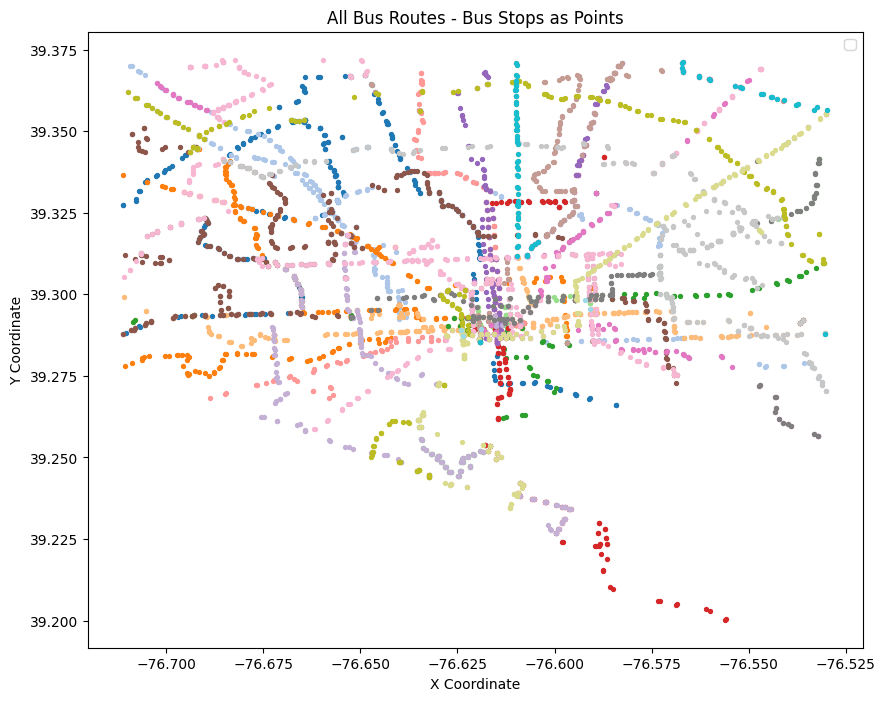

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the dataset
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

# Split 'Routes_Ser' into separate values and remove any leading/trailing spaces
Bus_Stops_row['Routes_Ser'] = Bus_Stops_row['Routes_Ser'].str.split(',')

# Create the bus_route_dict as before
bus_route_dict = {}
for _, row in Bus_Stops_row.iterrows():
    routes = row['Routes_Ser']
    stop_name = row['stop_name']
    x = row['X']
    y = row['Y']
    
    for route in routes:
        route = route.strip()  # Remove any leading/trailing spaces
        if route not in bus_route_dict:
            bus_route_dict[route] = []
        bus_route_dict[route].append({'stop_name': stop_name, 'X': x, 'Y': y})

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Function to generate points for a given bus
def create_route(bus_route):
    bus_route_stops = bus_route_dict.get(bus_route, [])

    # Extract X, Y coordinates for the bus route
    x_coords = [stop['X'] for stop in bus_route_stops]
    y_coords = [stop['Y'] for stop in bus_route_stops]

    return x_coords, y_coords

# Generate unique colors for each bus route (you can choose more or different colors)
colors = plt.cm.get_cmap('tab20', len(bus_route_dict))  # Get 20 different colors

# Plot the bus stops for all routes as points (without connecting them)
plt.figure(figsize=(10, 8))

# Iterate over all the bus routes and plot each one as points
for i, bus_route in enumerate(bus_route_dict.keys()):
    x_coords, y_coords = create_route(bus_route)
    
    # Plot each route's stops as points with a unique color
    plt.scatter(x_coords, y_coords, color=colors(i / len(bus_route_dict)),s=8)

# Title and labels
plt.title("All Bus Routes - Bus Stops as Points")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Remove the grid
plt.grid(False)  # Remove the grid

# Show the plot
plt.legend()
plt.show()


In [34]:
import pandas as pd

# Read the dataset
Bus_Stops_row = pd.read_csv('data/Bus_Stops.csv')

# Split 'Routes_Ser' into separate values and remove any leading/trailing spaces
Bus_Stops_row['Routes_Ser'] = Bus_Stops_row['Routes_Ser'].str.split(',')

# Get the unique bus routes and remove any leading/trailing spaces
bus_routes = sorted(set([route.strip() for routes in Bus_Stops_row['Routes_Ser'] for route in routes]))

# Output the available bus numbers in one line, separated by commas
print("Available bus routes:", ", ".join(bus_routes))


Available bus routes: 000, 103, 104, 105, 115, 120, 150, 154, 160, 163, 21, 210, 210; 215, 210; 215; 320; 411; 420; 310, 215, 215; 210, 22, 26, 28, 29, 30, 31, 310, 320, 33, 34, 36, 38, 410, 411, 411; 420, 420, 51, 52, 53, 54, 56, 57, 59, 62, 63, 65, 67, 69, 70, 71, 73, 75, 76, 77, 78, 79, 80, 82, 83, 85, 89, 91, 92, 94, 95, BL, BR, GD, GR, LM, NV, OR, PK, PR, RD, SV, YW


In [1]:
import folium

# This line allows you to input which bus route you want to see in the map
user_input = "105"  # Change this line with your selected bus route, e.g., "92", "94"

# Function to generate and display the map for the chosen bus route
def display_bus_route_map(route):
    filtered_stops = Bus_Stops_row[Bus_Stops_row['Routes_Ser'].apply(lambda x: route in x)]

    # Create a folium map centered on the first bus stop's coordinates
    map_center = [filtered_stops['Y'].iloc[0], filtered_stops['X'].iloc[0]]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add markers for each stop on the map
    for index, row in filtered_stops.iterrows():
        lat = row['Y']
        lon = row['X']
        stop_name = row['stop_name']
        
        folium.Marker([lat, lon], popup=stop_name).add_to(m)

    # Display the map (for Jupyter, IPython, or save it as HTML)
    return m

# Call the function to display the map for the bus route selected in the previous line
display_bus_route_map(user_input)


NameError: name 'Bus_Stops_row' is not defined

# 找空白，加站点

In [2]:
Bus_Stops = pd.read_csv('data/Bus_Stops.csv')

In [3]:
print(Bus_Stops.columns)

Index(['Y', 'X', 'stop_name', 'Rider_On', 'Rider_Off', 'Rider_Tota',
       'Stop_Rider', 'Routes_Ser', 'Distributi', 'Mode', 'Shelter', 'County',
       'stop_id'],
      dtype='object')


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import folium
from folium import plugins
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from shapely.geometry import LineString, Point
from shapely import wkt
import time
from datetime import datetime
from tqdm import tqdm


def load_data(bus_stops_path, nodes_path, edges_path):
    """加载所有需要的数据"""
    print("Loading data...")
    Bus_Stops = pd.read_csv(bus_stops_path)
    nodes_drive = pd.read_csv(nodes_path)
    edges_drive = pd.read_csv(edges_path)

    # 提取路线信息
    route_stops = {}
    for _, row in Bus_Stops.iterrows():
        if isinstance(row['Routes_Ser'], str):
            routes = row['Routes_Ser'].split(',')
            for route in routes:
                route = route.strip()
                if route not in route_stops:
                    route_stops[route] = []
                route_stops[route].append({
                    'stop_name': row['stop_name'],
                    'X': row['X'],
                    'Y': row['Y']
                })

    return Bus_Stops, nodes_drive, edges_drive, route_stops


def create_road_network(nodes_drive, edges_drive):
    """创建道路网络"""
    print("Creating road network...")
    road_network = nx.DiGraph()

    valid_highways = ['primary', 'secondary', 'tertiary', 'residential',
                      'primary_link', 'secondary_link', 'tertiary_link']

    for _, edge in tqdm(edges_drive.iterrows(), total=len(edges_drive)):
        if edge['highway'] in valid_highways:
            if isinstance(edge.get('geometry'), str):
                geometry = wkt.loads(edge['geometry'])
            else:
                start = nodes_drive[nodes_drive['osmid']
                                    == edge['u']][['x', 'y']].values[0]
                end = nodes_drive[nodes_drive['osmid']
                                  == edge['v']][['x', 'y']].values[0]
                geometry = LineString([start, end])

            road_network.add_edge(
                edge['u'],
                edge['v'],
                length=edge['length'],
                highway=edge['highway'],
                name=edge.get('name', ''),
                geometry=geometry
            )

    return road_network


def find_demand_centers(Bus_Stops, bandwidth=0.01):
    """使用KDE找到需求中心"""
    print("Finding demand centers...")
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    # 创建网格点
    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    # 计算密度
    densities = np.exp(kde.score_samples(grid_points))

    # 找到高密度点
    high_density_mask = densities > np.percentile(densities, 90)
    high_density_points = grid_points[high_density_mask]

    # 聚类找到中心
    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_density_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = high_density_points[clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers), kde


def find_nearest_road_point(point, road_network, max_distance=0.001):
    """找到最近的道路点"""
    point = Point(point)
    min_dist = float('inf')
    best_position = None
    best_edge = None

    for u, v, data in road_network.edges(data=True):
        if 'geometry' in data:
            line = data['geometry']
            dist = point.distance(line)

            if dist < min_dist and dist < max_distance:
                min_dist = dist
                best_edge = (u, v)
                best_position = line.interpolate(line.project(point))

    return best_position, best_edge


def find_path_between_centers(start_center, end_center, road_network, nodes_drive):
    """找到两个中心之间的路径"""
    start_point, start_edge = find_nearest_road_point(
        start_center, road_network)
    end_point, end_edge = find_nearest_road_point(end_center, road_network)

    if start_edge is None or end_edge is None:
        return None

    # 使用Dijkstra算法找到最短路径
    try:
        path = nx.shortest_path(road_network,
                                start_edge[0],
                                end_edge[1],
                                weight='length')
        return path
    except:
        return None


def generate_stops_along_path(path, road_network, Bus_Stops, route_stops,
                              min_distance=500, max_distance=1000):
    """在路径上生成站点"""
    print("Generating stops along path...")
    stops = []
    current_distance = 0
    path_geometry = []

    # 构建完整的路径几何形状
    for i in range(len(path)-1):
        edge_data = road_network.get_edge_data(path[i], path[i+1])
        if edge_data and 'geometry' in edge_data:
            path_geometry.append(edge_data['geometry'])

    if not path_geometry:
        return []

    # 合并所有线段
    full_path = LineString([coord for line in path_geometry
                            for coord in list(line.coords)])

    # 找到可能的换乘站
    transfer_points = []
    for _, row in Bus_Stops.iterrows():
        point = Point(row['X'], row['Y'])
        if point.distance(full_path) < 0.001:  # 约100米
            transfer_points.append({
                'point': point,
                'distance': full_path.project(point)
            })

    # 排序换乘站
    transfer_points.sort(key=lambda x: x['distance'])

    # 生成站点
    current_distance = 0
    while current_distance < full_path.length:
        # 检查是否有附近的换乘站
        nearest_transfer = None
        for transfer in transfer_points:
            if abs(transfer['distance'] - current_distance) < 0.001:  # 约100米
                nearest_transfer = transfer
                break

        if nearest_transfer:
            point = nearest_transfer['point']
        else:
            point = full_path.interpolate(current_distance)

        stops.append(point)
        current_distance += (min_distance + max_distance) / 2 / 111000  # 转换为度

    return stops


def create_interactive_map(Bus_Stops, stops, road_network, kde):
    """创建交互式地图"""
    print("Creating interactive map...")

    # 计算中心点
    center_lat = np.mean(Bus_Stops['Y'])
    center_lon = np.mean(Bus_Stops['X'])

    # 创建地图
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

    # 添加现有站点
    for _, stop in Bus_Stops.iterrows():
        folium.CircleMarker(
            location=[stop['Y'], stop['X']],
            radius=3,
            color='blue',
            fill=True,
            popup=f"Existing Stop: {stop['stop_name']}",
            tooltip=f"Riders: {stop['Rider_Tota']}"
        ).add_to(m)

    # 添加道路网络
    for _, _, data in road_network.edges(data=True):
        if 'geometry' in data:
            coords = list(data['geometry'].coords)
            locations = [[y, x] for x, y in coords]
            folium.PolyLine(
                locations=locations,
                weight=2,
                color='gray',
                opacity=0.5
            ).add_to(m)

    # 添加新站点
    stop_coords = []
    for i, stop in enumerate(stops):
        location = [stop.y, stop.x]
        stop_coords.append(location)
        folium.CircleMarker(
            location=location,
            radius=5,
            color='red',
            fill=True,
            popup=f'Proposed Stop {i+1}',
            tooltip=f'Stop {i+1}'
        ).add_to(m)

    # 添加路线
    if len(stop_coords) > 1:
        folium.PolyLine(
            locations=stop_coords,
            weight=3,
            color='red',
            opacity=0.8
        ).add_to(m)

    # 添加需求热力图
    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T
    densities = np.exp(kde.score_samples(grid_points))

    heat_data = [[point[1], point[0], density]
                 for point, density in zip(grid_points, densities)]
    plugins.HeatMap(heat_data).add_to(m)

    # 添加图层控制
    folium.LayerControl().add_to(m)

    return m


def main():
    start_time = time.time()
    print(f"Starting process at {datetime.now().strftime('%H:%M:%S')}")

    # 加载数据
    Bus_Stops, nodes_drive, edges_drive, route_stops = load_data(
        'data/Bus_Stops.csv',
        'data/nodes_drive.csv',
        'data/edges_drive.csv'
    )

    # 创建道路网络
    road_network = create_road_network(nodes_drive, edges_drive)

    # 找到需求中心
    demand_centers, kde = find_demand_centers(Bus_Stops)

    # 找到中心之间的路径并生成站点
    all_stops = []
    for i in range(len(demand_centers)-1):
        path = find_path_between_centers(
            demand_centers[i],
            demand_centers[i+1],
            road_network,
            nodes_drive
        )
        if path:
            stops = generate_stops_along_path(
                path,
                road_network,
                Bus_Stops,
                route_stops
            )
            all_stops.extend(stops)

    # 创建交互式地图
    m = create_interactive_map(Bus_Stops, all_stops, road_network, kde)

    # 保存地图
    output_file = f'bus_route_map_{datetime.now().strftime("%Y%m%d_%H%M%S")}.html'
    m.save(output_file)

    # 打印结果
    print("\nResults:")
    print(f"Number of demand centers: {len(demand_centers)}")
    print(f"Number of proposed stops: {len(all_stops)}")
    print("\nProposed stop coordinates:")
    for i, stop in enumerate(all_stops):
        print(f"Stop {i+1}: ({stop.x:.6f}, {stop.y:.6f})")

    end_time = time.time()
    print(f"\nProcess completed in {(end_time - start_time):.2f} seconds")
    print(f"Map saved as {output_file}")


if __name__ == "__main__":
    main()

Starting process at 18:21:13
Loading data...


/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_29733/912746591.py:20: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_drive = pd.read_csv(edges_path)


Creating road network...


100%|██████████| 91227/91227 [00:03<00:00, 25833.78it/s]
/opt/anaconda3/envs/matplotlib/lib/python3.13/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


Finding demand centers...
Creating interactive map...


/opt/anaconda3/envs/matplotlib/lib/python3.13/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(



Results:
Number of demand centers: 1
Number of proposed stops: 0

Proposed stop coordinates:

Process completed in 41.54 seconds
Map saved as bus_route_map_20250127_182139.html


/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_29733/3347151975.py:38: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_drive = pd.read_csv(edges_path)
/opt/anaconda3/envs/matplotlib/lib/python3.13/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_29733/3347151975.py:270: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_29733/3347151975.py:270: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/n4/_kd1hxg514q7fqtzxddcvqyh0000gp/T/ipykernel_29733/3347151975.py:270: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

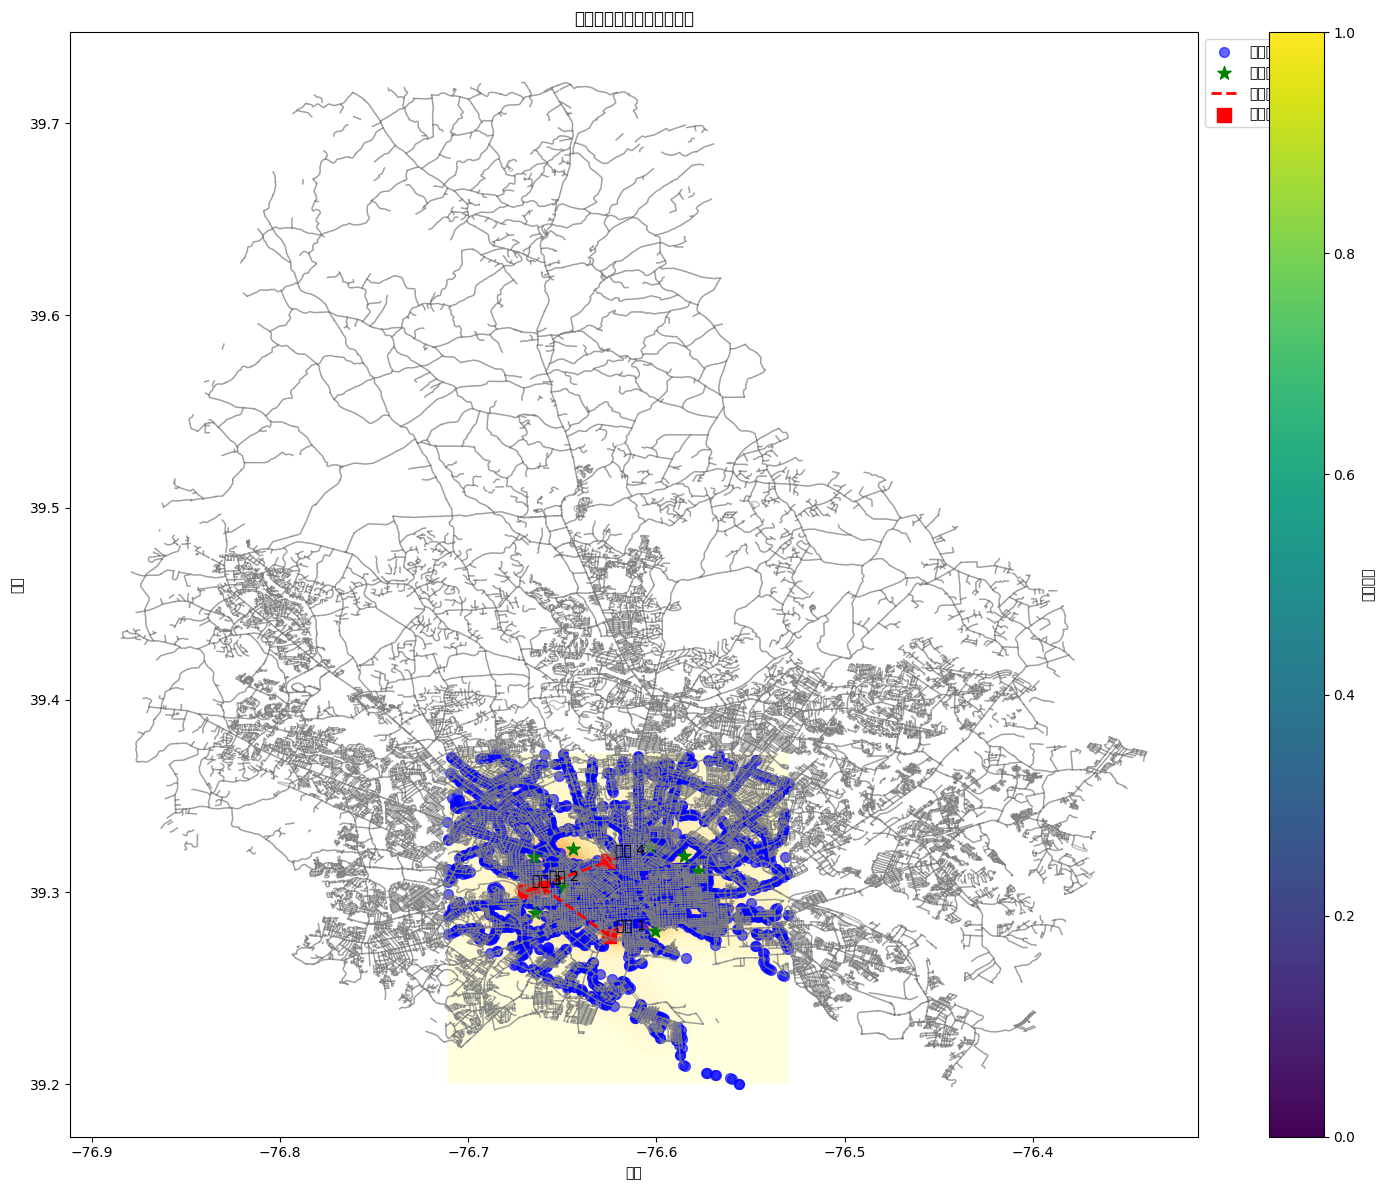


建议的新路线站点坐标：
站点 1: 经度 = -76.624985, 纬度 = 39.277116
站点 2: 经度 = -76.660674, 纬度 = 39.302599
站点 3: 经度 = -76.670065, 纬度 = 39.300377
站点 4: 经度 = -76.625514, 纬度 = 39.316059

换乘机会：


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import networkx as nx
from shapely.geometry import LineString, Point
from shapely import wkt


def load_data(bus_stops_path):
    """加载公交站点数据并提取路线信息"""
    Bus_Stops = pd.read_csv(bus_stops_path)

    # 提取路线信息
    route_stops = {}
    for _, row in Bus_Stops.iterrows():
        if isinstance(row['Routes_Ser'], str):
            routes = row['Routes_Ser'].split(',')
            for route in routes:
                route = route.strip()
                if route not in route_stops:
                    route_stops[route] = []
                route_stops[route].append({
                    'stop_name': row['stop_name'],
                    'X': row['X'],
                    'Y': row['Y']
                })

    return Bus_Stops, route_stops


def load_road_network(nodes_path, edges_path):
    """加载道路网络数据"""
    nodes_drive = pd.read_csv(nodes_path)
    edges_drive = pd.read_csv(edges_path)

    # 创建道路网络图
    road_network = nx.DiGraph()

    # 添加边
    valid_highways = ['primary', 'secondary', 'tertiary', 'residential',
                      'primary_link', 'secondary_link', 'tertiary_link']

    for _, edge in edges_drive.iterrows():
        if edge['highway'] in valid_highways:
            # 将geometry字符串转换为LineString对象
            if isinstance(edge.get('geometry'), str):
                geometry = wkt.loads(edge['geometry'])
            else:
                # 如果没有geometry，使用起点和终点创建直线
                start = nodes_drive[nodes_drive['osmid']
                                    == edge['u']][['x', 'y']].values[0]
                end = nodes_drive[nodes_drive['osmid']
                                  == edge['v']][['x', 'y']].values[0]
                geometry = LineString([start, end])

            road_network.add_edge(
                edge['u'],
                edge['v'],
                length=edge['length'],
                highway=edge['highway'],
                name=edge.get('name', ''),
                geometry=geometry
            )

    return road_network, nodes_drive, edges_drive


def calculate_density(Bus_Stops, bandwidth=0.01):
    """计算需求密度"""
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde


def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    """找到需求中心"""
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[
                clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)


def map_stop_to_road(stop_point, road_network, nodes_drive, max_distance=0.001):
    """将站点映射到最近的道路上"""
    min_dist = float('inf')
    best_edge = None
    best_position = None

    point = Point(stop_point)

    for u, v, data in road_network.edges(data=True):
        if 'geometry' in data:
            line = data['geometry']
            dist = point.distance(line)

            if dist < min_dist and dist < max_distance:
                min_dist = dist
                best_edge = (u, v)
                best_position = line.interpolate(line.project(point))

    return best_edge, best_position


def optimize_route_with_roads(points, road_network, nodes_drive, route_stops):
    """优化路线并映射到道路网络"""
    if len(points) < 2:
        return None, []

    # 创建图并添加节点
    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=(point[0], point[1]))

    # 连接最近的节点
    for i in range(len(points)):
        distances = [np.sqrt(np.sum((points[i] - points[j])**2))
                     for j in range(len(points)) if i != j]
        nearest_indices = np.argsort(distances)[:3]

        for j in nearest_indices:
            G.add_edge(i, j, weight=distances[j])

    # 找到最小生成树
    mst = nx.minimum_spanning_tree(G)

    # 找到最长路径
    paths = dict(nx.all_pairs_shortest_path_length(mst))
    max_length = 0
    start_node = end_node = 0

    for i in paths:
        for j in paths[i]:
            if paths[i][j] > max_length:
                max_length = paths[i][j]
                start_node = i
                end_node = j

    # 获取路径
    route_path = nx.shortest_path(mst, start_node, end_node)
    optimized_route = np.array([points[i] for i in route_path])

    # 映射到道路上
    mapped_stops = []
    for stop in optimized_route:
        edge, position = map_stop_to_road(stop, road_network, nodes_drive)
        if edge is not None and position is not None:
            mapped_stops.append({
                'position': position,
                'edge': edge
            })

    return mapped_stops, find_transfer_opportunities(mapped_stops, route_stops)


def find_transfer_opportunities(mapped_stops, route_stops, max_distance=0.003):
    """找到换乘机会"""
    transfer_stops = []
    for stop in mapped_stops:
        position = stop['position']
        nearby_stops = []

        for route, stops in route_stops.items():
            for route_stop in stops:
                dist = np.sqrt((position.x - route_stop['X'])**2 +
                               (position.y - route_stop['Y'])**2)
                if dist < max_distance:
                    nearby_stops.append({
                        'route': route,
                        'stop': route_stop,
                        'distance': dist
                    })

        if nearby_stops:
            transfer_stops.append({
                'point': position,
                'transfers': sorted(nearby_stops, key=lambda x: x['distance'])[:2]
            })

    return transfer_stops


def visualize_results_with_roads(Bus_Stops, xv, yv, densities, demand_centers,
                                 mapped_stops, transfer_stops, road_network, nodes_drive):
    """可视化结果"""
    plt.figure(figsize=(15, 12))

    # 绘制热力图
    plt.contourf(xv, yv, densities, levels=50, cmap='YlOrRd', alpha=0.6)

    # 绘制道路网络
    for _, _, data in road_network.edges(data=True):
        if 'geometry' in data:
            xs, ys = data['geometry'].xy
            plt.plot(xs, ys, color='gray', alpha=0.5, linewidth=1)

    # 绘制现有站点
    plt.scatter(Bus_Stops['X'], Bus_Stops['Y'],
                color='blue', s=50, alpha=0.6, label='现有站点')

    # 绘制需求中心
    if len(demand_centers) > 0:
        plt.scatter(demand_centers[:, 0], demand_centers[:, 1],
                    color='green', s=100, marker='*', label='需求中心')

    # 绘制新路线和站点
    if mapped_stops:
        # 绘制路线
        positions = [stop['position'] for stop in mapped_stops]
        xs = [pos.x for pos in positions]
        ys = [pos.y for pos in positions]
        plt.plot(xs, ys, color='red', linewidth=2,
                 linestyle='--', label='建议路线')

        # 绘制站点
        plt.scatter(xs, ys, color='red', s=100, marker='s', label='新站点')

        # 添加站点编号
        for i, (x, y) in enumerate(zip(xs, ys)):
            plt.annotate(f'站点 {i+1}', (x, y), xytext=(5, 5),
                         textcoords='offset points')

    # 绘制换乘站点
    if transfer_stops:
        transfer_xs = [t['point'].x for t in transfer_stops]
        transfer_ys = [t['point'].y for t in transfer_stops]
        plt.scatter(transfer_xs, transfer_ys, color='yellow', s=150,
                    marker='o', label='换乘站点')

    plt.colorbar(label='需求密度')
    plt.title('公交站点分布与建议新路线')
    plt.xlabel('经度')
    plt.ylabel('纬度')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


def check_coverage(point, Bus_Stops, radius=0.003):
    """检查是否已有站点覆盖"""
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False


def main():
    # 加载数据
    Bus_Stops, route_stops = load_data('data/Bus_Stops.csv')
    road_network, nodes_drive, edges_drive = load_road_network(
        'data/nodes_drive.csv',
        'data/edges_drive.csv'
    )

    # 计算密度
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # 找到需求中心
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # 优化路线并映射到实际道路
    mapped_stops, transfer_stops = optimize_route_with_roads(
        demand_centers,
        road_network,
        nodes_drive,
        route_stops
    )

    # 可视化结果
    visualize_results_with_roads(
        Bus_Stops,
        xv, yv,
        densities,
        demand_centers,
        mapped_stops,
        transfer_stops,
        road_network,
        nodes_drive
    )

    # 打印路线信息
    if mapped_stops:
        print("\n建议的新路线站点坐标：")
        for i, stop in enumerate(mapped_stops):
            print(
                f"站点 {i+1}: 经度 = {stop['position'].x:.6f}, 纬度 = {stop['position'].y:.6f}")

        print("\n换乘机会：")
        for transfer in transfer_stops:
            print(
                f"\n在坐标 ({transfer['point'].x:.6f}, {transfer['point'].y:.6f}):")
            for t in transfer['transfers']:
                print(f"- 可换乘线路 {t['route']}")


if __name__ == "__main__":
    main()

/opt/anaconda3/envs/matplotlib/lib/python3.13/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


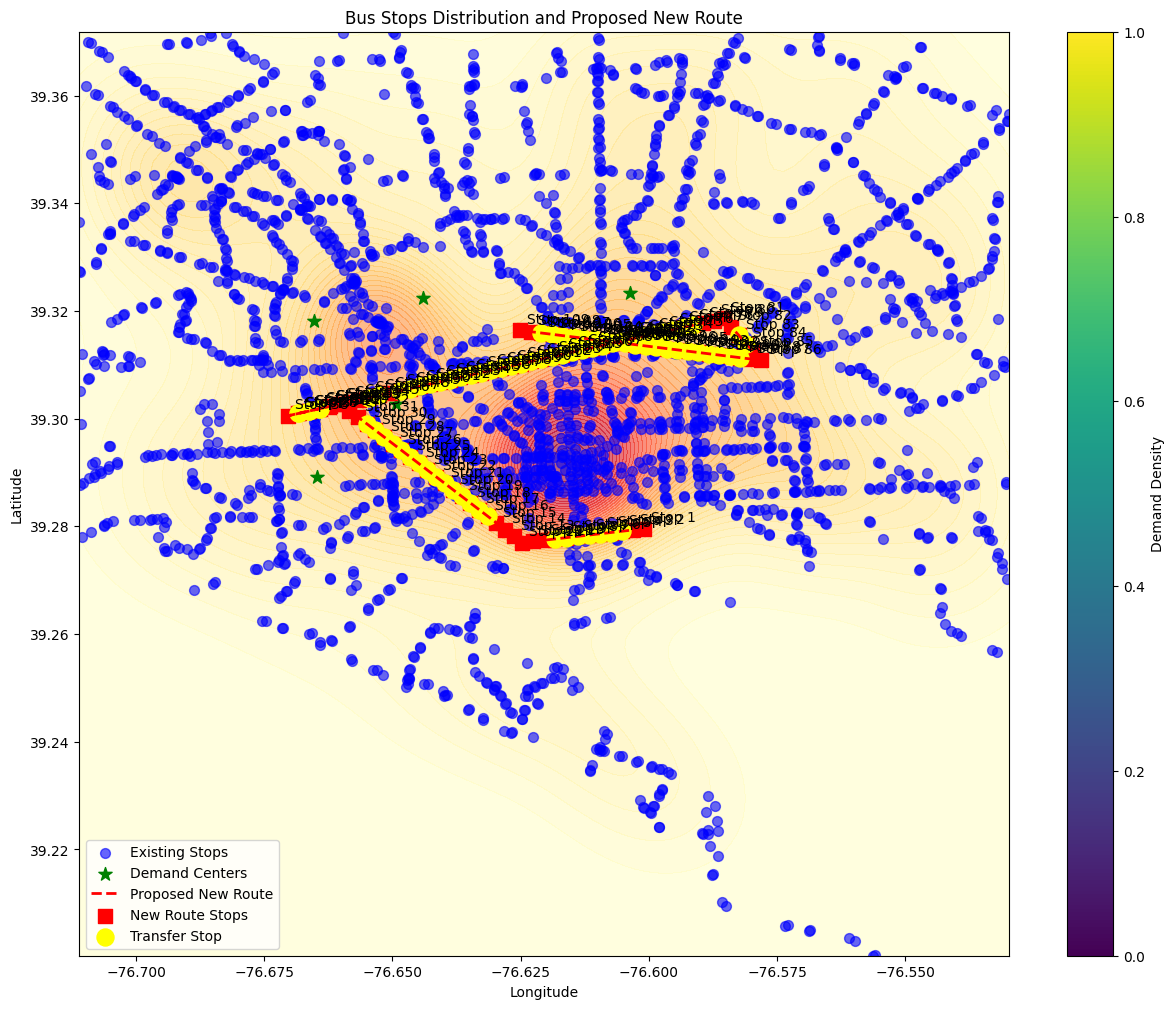


Proposed New Route Coordinates:
Stop 1: Longitude = -76.600999, Latitude = 39.279567
Stop 2: Longitude = -76.603150, Latitude = 39.279330
Stop 3: Longitude = -76.605301, Latitude = 39.279094
Stop 4: Longitude = -76.607452, Latitude = 39.278857
Stop 5: Longitude = -76.609603, Latitude = 39.278621
Stop 6: Longitude = -76.611754, Latitude = 39.278385
Stop 7: Longitude = -76.613905, Latitude = 39.278148
Stop 8: Longitude = -76.616056, Latitude = 39.277912
Stop 9: Longitude = -76.618207, Latitude = 39.277676
Stop 10: Longitude = -76.620358, Latitude = 39.277439
Stop 11: Longitude = -76.622509, Latitude = 39.277203
Stop 12: Longitude = -76.624660, Latitude = 39.276966
Stop 13: Longitude = -76.626346, Latitude = 39.278194
Stop 14: Longitude = -76.628033, Latitude = 39.279422
Stop 15: Longitude = -76.629719, Latitude = 39.280650
Stop 16: Longitude = -76.631406, Latitude = 39.281878
Stop 17: Longitude = -76.633092, Latitude = 39.283106
Stop 18: Longitude = -76.634778, Latitude = 39.284334
Stop

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import networkx as nx


def load_data(bus_stops_path):
    """Load bus stops data and extract route information"""
    Bus_Stops = pd.read_csv(bus_stops_path)

    # Extract route information
    route_stops = {}
    for _, row in Bus_Stops.iterrows():
        if isinstance(row['Routes_Ser'], str):
            routes = row['Routes_Ser'].split(',')
            for route in routes:
                route = route.strip()
                if route not in route_stops:
                    route_stops[route] = []
                route_stops[route].append({
                    'stop_name': row['stop_name'],
                    'X': row['X'],
                    'Y': row['Y']
                })

    return Bus_Stops, route_stops


def calculate_density(Bus_Stops, bandwidth=0.01):
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde


def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[
                clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)


def check_coverage(point, Bus_Stops, radius=0.003):
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False


def find_nearest_route_stops(point, route_stops, max_distance=0.003):
    nearby_stops = []
    for route, stops in route_stops.items():
        for stop in stops:
            dist = np.sqrt((point[0] - stop['X'])**2 +
                           (point[1] - stop['Y'])**2)
            if dist < max_distance:
                nearby_stops.append({
                    'route': route,
                    'stop': stop,
                    'distance': dist
                })
    return sorted(nearby_stops, key=lambda x: x['distance'])


def interpolate_stops(route_points, avg_distance=0.002):
    """Add intermediate stops to maintain consistent stop spacing"""
    detailed_route = []

    for i in range(len(route_points) - 1):
        start = route_points[i]
        end = route_points[i + 1]

        # Calculate distance between points
        dist = np.sqrt(np.sum((end - start) ** 2))

        # Calculate number of intermediate stops needed
        n_stops = int(dist / avg_distance)

        # Add current stop
        detailed_route.append(start)

        # Add intermediate stops
        if n_stops > 1:
            for j in range(1, n_stops):
                t = j / n_stops
                intermediate = start + t * (end - start)
                detailed_route.append(intermediate)

    # Add final stop
    detailed_route.append(route_points[-1])

    return np.array(detailed_route)


def optimize_route(points, route_stops):
    if len(points) < 2:
        return None, []

    # Create a graph for the route
    G = nx.Graph()

    # Add all points as nodes
    for i, point in enumerate(points):
        G.add_node(i, pos=(point[0], point[1]))

    # Connect each point to its nearest neighbors
    for i in range(len(points)):
        distances = [np.sqrt(np.sum((points[i] - points[j])**2))
                     for j in range(len(points)) if i != j]
        # Connect to 3 nearest neighbors
        nearest_indices = np.argsort(distances)[:3]

        for j in nearest_indices:
            G.add_edge(i, j, weight=distances[j])

    # Find the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Find the longest path in the tree
    paths = dict(nx.all_pairs_shortest_path_length(mst))
    max_length = 0
    start_node = end_node = 0

    for i in paths:
        for j in paths[i]:
            if paths[i][j] > max_length:
                max_length = paths[i][j]
                start_node = i
                end_node = j

    # Get the route as a sequence of points
    route_path = nx.shortest_path(mst, start_node, end_node)
    optimized_route = np.array([points[i] for i in route_path])

    # Add intermediate stops
    detailed_route = interpolate_stops(optimized_route)

    # Find transfer stops
    transfer_stops = []
    for point in detailed_route:
        nearby_stops = find_nearest_route_stops(point, route_stops)
        if nearby_stops:
            transfer_stops.append({
                'point': point,
                'transfers': nearby_stops[:2]
            })

    return detailed_route, transfer_stops


def visualize_results(Bus_Stops, xv, yv, densities, demand_centers, new_route=None, transfer_stops=None):
    plt.figure(figsize=(15, 12))

    # Plot heatmap
    plt.contourf(xv, yv, densities, levels=50, cmap='YlOrRd', alpha=0.6)

    # Plot existing stops
    plt.scatter(Bus_Stops['X'], Bus_Stops['Y'],
                color='blue', s=50, alpha=0.6, label='Existing Stops')

    # Plot demand centers
    if len(demand_centers) > 0:
        plt.scatter(demand_centers[:, 0], demand_centers[:, 1],
                    color='green', s=100, marker='*', label='Demand Centers')

    # Plot new route
    if new_route is not None:
        # Plot route line
        plt.plot(new_route[:, 0], new_route[:, 1],
                 color='red', linewidth=2, linestyle='--', label='Proposed New Route')

        # Plot route stops
        plt.scatter(new_route[:, 0], new_route[:, 1],
                    color='red', s=100, marker='s', label='New Route Stops')

        # Add stop numbers
        for i, point in enumerate(new_route):
            plt.annotate(f'Stop {i+1}',
                         (point[0], point[1]),
                         xytext=(5, 5),
                         textcoords='offset points')

    # Plot transfer stops
    transfer_label_added = False
    if transfer_stops:
        for transfer in transfer_stops:
            label = 'Transfer Stop' if not transfer_label_added else ""
            plt.scatter(transfer['point'][0], transfer['point'][1],
                        color='yellow', s=150, marker='o',
                        label=label)
            transfer_label_added = True

    plt.colorbar(label='Demand Density')
    plt.title('Bus Stops Distribution and Proposed New Route')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


def main():
    # Load data
    Bus_Stops, route_stops = load_data('data/Bus_Stops.csv')

    # Calculate density
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # Find demand centers
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # Optimize route and find transfers
    new_route, transfer_stops = optimize_route(demand_centers, route_stops)

    # Visualize results
    visualize_results(Bus_Stops, xv, yv, densities, demand_centers,
                      new_route, transfer_stops)

    # Print route information
    if new_route is not None:
        print("\nProposed New Route Coordinates:")
        for i, point in enumerate(new_route):
            print(
                f"Stop {i+1}: Longitude = {point[0]:.6f}, Latitude = {point[1]:.6f}")

        print("\nTransfer Opportunities:")
        for transfer in transfer_stops:
            print(
                f"\nAt coordinates ({transfer['point'][0]:.6f}, {transfer['point'][1]:.6f}):")
            for t in transfer['transfers']:
                print(f"- Transfer to Route {t['route']}")


if __name__ == "__main__":
    main()

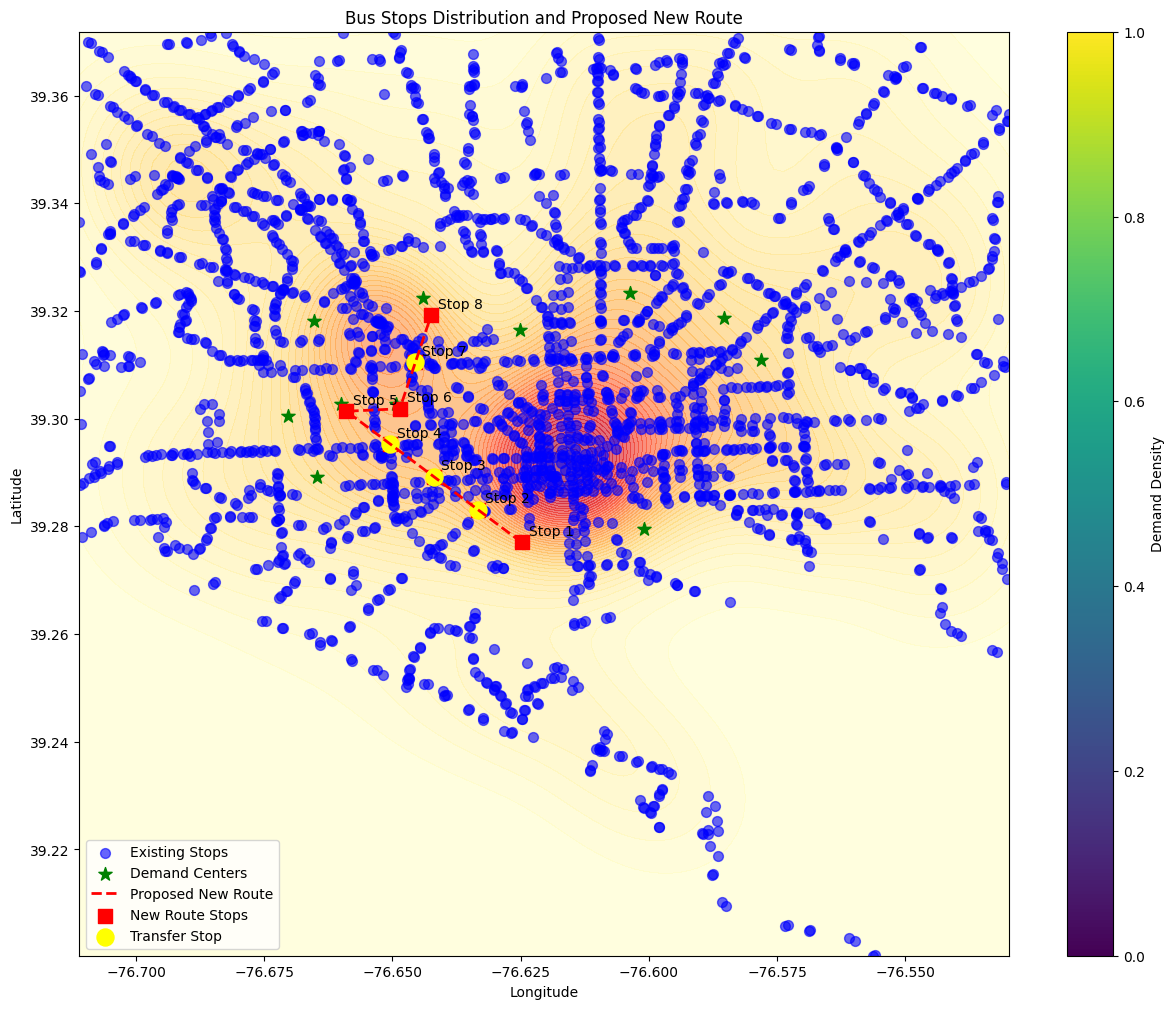


Proposed New Route Coordinates:
Stop 1: Longitude = -76.624802, Latitude = 39.277029
Stop 2: Longitude = -76.633344, Latitude = 39.283118
Stop 3: Longitude = -76.641886, Latitude = 39.289207
Stop 4: Longitude = -76.650428, Latitude = 39.295295
Stop 5: Longitude = -76.658970, Latitude = 39.301384
Stop 6: Longitude = -76.648562, Latitude = 39.301844
Stop 7: Longitude = -76.645503, Latitude = 39.310532
Stop 8: Longitude = -76.642444, Latitude = 39.319220

Stop Spacing Statistics:
Average: 986 meters
Minimum: 899 meters
Maximum: 1000 meters

Transfer Opportunities:

At coordinates (-76.633344, 39.283118):
- Transfer to Route YW
- Transfer to Route YW

At coordinates (-76.641886, 39.289207):
- Transfer to Route PR
- Transfer to Route 78

At coordinates (-76.650428, 39.295295):
- Transfer to Route 80
- Transfer to Route 26

At coordinates (-76.645503, 39.310532):
- Transfer to Route GD
- Transfer to Route NV


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from geopy.distance import geodesic
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')


def load_data(bus_stops_path, edges_path, nodes_path):
    """Load all required data"""
    # Load bus stops data
    Bus_Stops = pd.read_csv(bus_stops_path)

    # Load network data
    edges_df = pd.read_csv(edges_path)
    nodes_df = pd.read_csv(nodes_path)

    # Convert edges to GeoDataFrame with proper geometry
    def parse_geometry(geom_str):
        if not isinstance(geom_str, str):
            return None
        try:
            # Remove LINESTRING and parentheses, split coordinates
            coords_str = geom_str.replace('LINESTRING', '').replace(
                '(', '').replace(')', '').strip()
            coords_list = [tuple(map(float, coord.strip().split()))
                           for coord in coords_str.split(',')]
            return LineString(coords_list)
        except:
            return None

    edges_gdf = gpd.GeoDataFrame(edges_df)
    edges_gdf['geometry'] = edges_gdf['geometry'].apply(parse_geometry)

    # Extract route information
    route_stops = {}
    for _, row in Bus_Stops.iterrows():
        if isinstance(row['Routes_Ser'], str):
            routes = row['Routes_Ser'].split(',')
            for route in routes:
                route = route.strip()
                if route not in route_stops:
                    route_stops[route] = []
                route_stops[route].append({
                    'stop_name': row['stop_name'],
                    'X': row['X'],
                    'Y': row['Y']
                })

    return Bus_Stops, route_stops, edges_gdf, nodes_df

def calculate_density(Bus_Stops, bandwidth=0.01):
    """Calculate density using KDE"""
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde

def check_coverage(point, Bus_Stops, radius=0.003):
    """Check if a point is already covered by existing stops"""
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False

def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    """Find centers of high demand areas"""
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)

def map_point_to_nearest_edge(point, edges_gdf):
    """Map a point to the nearest edge in the road network"""
    min_distance = float('inf')
    nearest_edge = None
    mapped_point = None
    
    point_geom = Point(point)
    
    for idx, edge in edges_gdf.iterrows():
        if edge.geometry is None:
            continue
            
        distance = point_geom.distance(edge.geometry)
        
        if distance < min_distance:
            min_distance = distance
            nearest_edge = edge
            mapped_point = nearest_points(point_geom, edge.geometry)[1]
    
    return mapped_point, nearest_edge

def adjust_stop_spacing(route_points, min_dist=500, max_dist=1000):
    """Adjust spacing between stops to be between min_dist and max_dist meters"""
    if len(route_points) < 2:
        return route_points
        
    adjusted_points = [route_points[0]]
    
    for i in range(1, len(route_points)):
        last_point = adjusted_points[-1]
        current_point = route_points[i]
        
        dist = geodesic(
            (last_point.y, last_point.x),
            (current_point.y, current_point.x)
        ).meters
        
        if dist >= min_dist and dist <= max_dist:
            adjusted_points.append(current_point)
        elif dist > max_dist:
            num_new_stops = int(dist / max_dist)
            for j in range(1, num_new_stops + 1):
                ratio = (j * max_dist) / dist
                new_x = last_point.x + (current_point.x - last_point.x) * ratio
                new_y = last_point.y + (current_point.y - last_point.y) * ratio
                adjusted_points.append(Point(new_x, new_y))
            
    return adjusted_points

def find_nearest_route_stops(point, route_stops, max_distance=0.003):
    """Find nearest existing route stops to a given point"""
    nearby_stops = []
    for route, stops in route_stops.items():
        for stop in stops:
            dist = np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2)
            if dist < max_distance:
                nearby_stops.append({
                    'route': route,
                    'stop': stop,
                    'distance': dist
                })
    return sorted(nearby_stops, key=lambda x: x['distance'])

def optimize_route(points, route_stops, edges_gdf, nodes_df):
    """Optimize route and map stops to road network"""
    if len(points) < 2:
        return None, []

    # Create graph for route optimization
    G = nx.Graph()
    
    # Map points to nearest edges
    mapped_points = []
    for point in points:
        mapped_point, edge = map_point_to_nearest_edge(point, edges_gdf)
        if mapped_point is not None:
            mapped_points.append(mapped_point)
    
    if len(mapped_points) < 2:
        return None, []
    
    # Create graph connections
    for i in range(len(mapped_points)):
        G.add_node(i, pos=(mapped_points[i].x, mapped_points[i].y))
        
    for i in range(len(mapped_points)):
        distances = [geodesic(
            (mapped_points[i].y, mapped_points[i].x),
            (mapped_points[j].y, mapped_points[j].x)
        ).meters for j in range(len(mapped_points)) if i != j]
        nearest_indices = np.argsort(distances)[:3]
        
        for j in nearest_indices:
            if i != j:
                G.add_edge(i, j, weight=distances[j])
    
    # Find optimal path
    paths = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    start_node = end_node = 0
    
    for i in paths:
        for j in paths[i]:
            if paths[i][j] > max_length:
                max_length = paths[i][j]
                start_node = i
                end_node = j
    
    try:
        route_path = nx.shortest_path(G, start_node, end_node)
        route_points = [mapped_points[i] for i in route_path]
    except nx.NetworkXNoPath:
        return None, []
    
    # Adjust stop spacing
    adjusted_points = adjust_stop_spacing(route_points)
    
    # Find transfer opportunities
    transfer_stops = []
    for point in adjusted_points:
        nearby_stops = find_nearest_route_stops(
            (point.x, point.y),
            route_stops
        )
        if nearby_stops:
            transfer_stops.append({
                'point': (point.x, point.y),
                'transfers': nearby_stops[:2]
            })
    
    return np.array([(p.x, p.y) for p in adjusted_points]), transfer_stops

def visualize_results(Bus_Stops, xv, yv, densities, demand_centers, new_route=None, transfer_stops=None):
    """Visualize the results including density map, existing stops, and new route"""
    plt.figure(figsize=(15, 12))

    # Plot density heatmap
    plt.contourf(xv, yv, densities, levels=50, cmap='YlOrRd', alpha=0.6)

    # Plot existing stops
    plt.scatter(Bus_Stops['X'], Bus_Stops['Y'],
                color='blue', s=50, alpha=0.6, label='Existing Stops')

    # Plot demand centers
    if len(demand_centers) > 0:
        plt.scatter(demand_centers[:, 0], demand_centers[:, 1],
                    color='green', s=100, marker='*', label='Demand Centers')

    # Plot new route
    if new_route is not None:
        plt.plot(new_route[:, 0], new_route[:, 1],
                 color='red', linewidth=2, linestyle='--', label='Proposed New Route')
        plt.scatter(new_route[:, 0], new_route[:, 1],
                    color='red', s=100, marker='s', label='New Route Stops')

        for i, point in enumerate(new_route):
            plt.annotate(f'Stop {i+1}',
                         (point[0], point[1]),
                         xytext=(5, 5),
                         textcoords='offset points')

    # Plot transfer stops
    transfer_label_added = False
    if transfer_stops:
        for transfer in transfer_stops:
            label = 'Transfer Stop' if not transfer_label_added else ""
            plt.scatter(transfer['point'][0], transfer['point'][1],
                        color='yellow', s=150, marker='o',
                        label=label)
            transfer_label_added = True

    plt.colorbar(label='Demand Density')
    plt.title('Bus Stops Distribution and Proposed New Route')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

def main():
    # Load data
    Bus_Stops, route_stops, edges_gdf, nodes_df = load_data(
        'data/Bus_Stops.csv',
        'data/edges_drive.csv',
        'data/nodes_drive.csv'
    )

    # Calculate density
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # Find demand centers
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # Optimize route and map to road network
    new_route, transfer_stops = optimize_route(demand_centers, route_stops, edges_gdf, nodes_df)

    # Visualize results
    visualize_results(Bus_Stops, xv, yv, densities, demand_centers, new_route, transfer_stops)

    # Print route information
    if new_route is not None:
        print("\nProposed New Route Coordinates:")
        for i, point in enumerate(new_route):
            print(f"Stop {i+1}: Longitude = {point[0]:.6f}, Latitude = {point[1]:.6f}")

        if len(new_route) > 1:
            distances = []
            for j in range(len(new_route)-1):
                dist = geodesic(
                    (new_route[j][1], new_route[j][0]),
                    (new_route[j+1][1], new_route[j+1][0])
                ).meters
                distances.append(dist)
            print(f"\nStop Spacing Statistics:")
            print(f"Average: {np.mean(distances):.0f} meters")
            print(f"Minimum: {min(distances):.0f} meters")
            print(f"Maximum: {max(distances):.0f} meters")

        print("\nTransfer Opportunities:")
        for transfer in transfer_stops:
            print(f"\nAt coordinates ({transfer['point'][0]:.6f}, {transfer['point'][1]:.6f}):")
            for t in transfer['transfers']:
                print(f"- Transfer to Route {t['route']}")

if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
from geopy.distance import geodesic
import geopandas as gpd
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

# ... (保持之前的其他函数不变，直到visualize_results) ...
def load_data(bus_stops_path, edges_path, nodes_path):
    """Load all required data"""
    # Load bus stops data
    Bus_Stops = pd.read_csv(bus_stops_path)

    # Load network data
    edges_df = pd.read_csv(edges_path)
    nodes_df = pd.read_csv(nodes_path)

    # Convert edges to GeoDataFrame with proper geometry
    def parse_geometry(geom_str):
        if not isinstance(geom_str, str):
            return None
        try:
            # Remove LINESTRING and parentheses, split coordinates
            coords_str = geom_str.replace('LINESTRING', '').replace(
                '(', '').replace(')', '').strip()
            coords_list = [tuple(map(float, coord.strip().split()))
                           for coord in coords_str.split(',')]
            return LineString(coords_list)
        except:
            return None

    edges_gdf = gpd.GeoDataFrame(edges_df)
    edges_gdf['geometry'] = edges_gdf['geometry'].apply(parse_geometry)

    # Extract route information
    route_stops = {}
    for _, row in Bus_Stops.iterrows():
        if isinstance(row['Routes_Ser'], str):
            routes = row['Routes_Ser'].split(',')
            for route in routes:
                route = route.strip()
                if route not in route_stops:
                    route_stops[route] = []
                route_stops[route].append({
                    'stop_name': row['stop_name'],
                    'X': row['X'],
                    'Y': row['Y']
                })

    return Bus_Stops, route_stops, edges_gdf, nodes_df

def calculate_density(Bus_Stops, bandwidth=0.01):
    """Calculate density using KDE"""
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde

def check_coverage(point, Bus_Stops, radius=0.003):
    """Check if a point is already covered by existing stops"""
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False

def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    """Find centers of high demand areas"""
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)

def map_point_to_nearest_edge(point, edges_gdf):
    """Map a point to the nearest edge in the road network"""
    min_distance = float('inf')
    nearest_edge = None
    mapped_point = None
    
    point_geom = Point(point)
    
    for idx, edge in edges_gdf.iterrows():
        if edge.geometry is None:
            continue
            
        distance = point_geom.distance(edge.geometry)
        
        if distance < min_distance:
            min_distance = distance
            nearest_edge = edge
            mapped_point = nearest_points(point_geom, edge.geometry)[1]
    
    return mapped_point, nearest_edge

def adjust_stop_spacing(route_points, min_dist=300, max_dist=500):
    """Adjust spacing between stops to be between min_dist and max_dist meters"""
    if len(route_points) < 2:
        return route_points
        
    adjusted_points = [route_points[0]]
    
    for i in range(1, len(route_points)):
        last_point = adjusted_points[-1]
        current_point = route_points[i]
        
        dist = geodesic(
            (last_point.y, last_point.x),
            (current_point.y, current_point.x)
        ).meters
        
        if dist >= min_dist and dist <= max_dist:
            adjusted_points.append(current_point)
        elif dist > max_dist:
            num_new_stops = int(dist / max_dist)
            for j in range(1, num_new_stops + 1):
                ratio = (j * max_dist) / dist
                new_x = last_point.x + (current_point.x - last_point.x) * ratio
                new_y = last_point.y + (current_point.y - last_point.y) * ratio
                adjusted_points.append(Point(new_x, new_y))
            
    return adjusted_points

def find_nearest_route_stops(point, route_stops, max_distance=0.003):
    """Find nearest existing route stops to a given point"""
    nearby_stops = []
    for route, stops in route_stops.items():
        for stop in stops:
            dist = np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2)
            if dist < max_distance:
                nearby_stops.append({
                    'route': route,
                    'stop': stop,
                    'distance': dist
                })
    return sorted(nearby_stops, key=lambda x: x['distance'])

def optimize_route(points, route_stops, edges_gdf, nodes_df):
    """Optimize route and map stops to road network"""
    if len(points) < 2:
        return None, []

    # Create graph for route optimization
    G = nx.Graph()
    
    # Map points to nearest edges
    mapped_points = []
    for point in points:
        mapped_point, edge = map_point_to_nearest_edge(point, edges_gdf)
        if mapped_point is not None:
            mapped_points.append(mapped_point)
    
    if len(mapped_points) < 2:
        return None, []
    
    # Create graph connections
    for i in range(len(mapped_points)):
        G.add_node(i, pos=(mapped_points[i].x, mapped_points[i].y))
        
    for i in range(len(mapped_points)):
        distances = [geodesic(
            (mapped_points[i].y, mapped_points[i].x),
            (mapped_points[j].y, mapped_points[j].x)
        ).meters for j in range(len(mapped_points)) if i != j]
        nearest_indices = np.argsort(distances)[:3]
        
        for j in nearest_indices:
            if i != j:
                G.add_edge(i, j, weight=distances[j])
    
    # Find optimal path
    paths = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    start_node = end_node = 0
    
    for i in paths:
        for j in paths[i]:
            if paths[i][j] > max_length:
                max_length = paths[i][j]
                start_node = i
                end_node = j
    
    try:
        route_path = nx.shortest_path(G, start_node, end_node)
        route_points = [mapped_points[i] for i in route_path]
    except nx.NetworkXNoPath:
        return None, []
    
    # Adjust stop spacing
    adjusted_points = adjust_stop_spacing(route_points)
    
    # Find transfer opportunities
    transfer_stops = []
    for point in adjusted_points:
        nearby_stops = find_nearest_route_stops(
            
            (point.x, point.y),
            route_stops
        )
        if nearby_stops:
            transfer_stops.append({
                'point': (point.x, point.y),
                'transfers': nearby_stops[:2]
            })
    
    return np.array([(p.x, p.y) for p in adjusted_points]), transfer_stops

def visualize_results_folium(Bus_Stops, demand_centers, new_route=None, transfer_stops=None, edges_gdf=None):
    """使用folium创建交互式地图可视化"""
    # 计算中心点
    center_lat = Bus_Stops['Y'].mean()
    center_lon = Bus_Stops['X'].mean()

    # 创建基础地图
    m = folium.Map(location=[center_lat, center_lon],
                   zoom_start=12,
                   tiles='cartodbpositron')

    # 添加道路网络
    if edges_gdf is not None:
        for _, edge in edges_gdf.iterrows():
            if edge.geometry is not None:
                coords = [(y, x) for x, y in edge.geometry.coords]
                folium.PolyLine(
                    coords,
                    weight=1,
                    color='gray',
                    opacity=0.5
                ).add_to(m)

    # 添加现有公交站点
    stops_group = folium.FeatureGroup(name='Existing Bus Stops')
    for _, stop in Bus_Stops.iterrows():
        folium.CircleMarker(
            location=[stop['Y'], stop['X']],
            radius=3,
            color='blue',
            fill=True,
            popup=f"Stop: {stop['stop_name']}",
            weight=2
        ).add_to(stops_group)
    stops_group.add_to(m)

    # 添加需求中心
    if len(demand_centers) > 0:
        demand_group = folium.FeatureGroup(name='Demand Centers')
        for i, center in enumerate(demand_centers):
            folium.CircleMarker(
                location=[center[1], center[0]],
                radius=5,
                color='green',
                fill=True,
                popup=f'Demand Center {i+1}',
                weight=2
            ).add_to(demand_group)
        demand_group.add_to(m)

    # 添加新路线
    if new_route is not None:
        route_group = folium.FeatureGroup(name='New Route')

        # 添加路线
        route_coords = [(y, x) for x, y in new_route]
        folium.PolyLine(
            route_coords,
            weight=3,
            color='red',
            opacity=0.8
        ).add_to(route_group)

        # 添加新站点
        for i, point in enumerate(new_route):
            folium.CircleMarker(
                location=[point[1], point[0]],
                radius=5,
                color='red',
                fill=True,
                popup=f'New Stop {i+1}',
                weight=2
            ).add_to(route_group)
        route_group.add_to(m)

    # 添加换乘站点
    if transfer_stops:
        transfer_group = folium.FeatureGroup(name='Transfer Stops')
        for i, transfer in enumerate(transfer_stops):
            popup_text = f"Transfer Stop {i+1}<br>"
            for t in transfer['transfers']:
                popup_text += f"- Route: {t['route']}<br>"

            folium.CircleMarker(
                location=[transfer['point'][1], transfer['point'][0]],
                radius=7,
                color='yellow',
                fill=True,
                popup=popup_text,
                weight=2
            ).add_to(transfer_group)
        transfer_group.add_to(m)

    # 添加图例控制
    folium.LayerControl().add_to(m)

    # 添加鼠标位置显示
    plugins.MousePosition().add_to(m)

    return m


def main():
    # 加载数据
    Bus_Stops, route_stops, edges_gdf, nodes_df = load_data(
        'data/Bus_Stops.csv',
        'data/edges_drive.csv',
        'data/nodes_drive.csv'
    )

    # 计算密度
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # 找到需求中心
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # 优化路线并映射到道路网络
    new_route, transfer_stops = optimize_route(
        demand_centers, route_stops, edges_gdf, nodes_df)

    # 使用folium创建可视化
    m = visualize_results_folium(
        Bus_Stops, demand_centers, new_route, transfer_stops, edges_gdf)

    # 保存地图
    m.save('bus_route_map.html')

    # 打印路线信息
    if new_route is not None:
        print("\nProposed New Route Coordinates:")
        for i, point in enumerate(new_route):
            print(
                f"Stop {i+1}: Longitude = {point[0]:.6f}, Latitude = {point[1]:.6f}")

        if len(new_route) > 1:
            distances = []
            for j in range(len(new_route)-1):
                dist = geodesic(
                    (new_route[j][1], new_route[j][0]),
                    (new_route[j+1][1], new_route[j+1][0])
                ).meters
                distances.append(dist)
            print(f"\nStop Spacing Statistics:")
            print(f"Average: {np.mean(distances):.0f} meters")
            print(f"Minimum: {min(distances):.0f} meters")
            print(f"Maximum: {max(distances):.0f} meters")

        print("\nTransfer Opportunities:")
        for transfer in transfer_stops:
            print(
                f"\nAt coordinates ({transfer['point'][0]:.6f}, {transfer['point'][1]:.6f}):")
            for t in transfer['transfers']:
                print(f"- Transfer to Route {t['route']}")


if __name__ == "__main__":
    main()


Proposed New Route Coordinates:
Stop 1: Longitude = -76.624802, Latitude = 39.277029
Stop 2: Longitude = -76.629073, Latitude = 39.280074
Stop 3: Longitude = -76.633344, Latitude = 39.283118
Stop 4: Longitude = -76.637615, Latitude = 39.286162
Stop 5: Longitude = -76.641886, Latitude = 39.289207
Stop 6: Longitude = -76.646157, Latitude = 39.292251
Stop 7: Longitude = -76.650428, Latitude = 39.295295
Stop 8: Longitude = -76.654699, Latitude = 39.298340
Stop 9: Longitude = -76.658970, Latitude = 39.301384
Stop 10: Longitude = -76.653182, Latitude = 39.301640
Stop 11: Longitude = -76.650725, Latitude = 39.305719
Stop 12: Longitude = -76.648268, Latitude = 39.309798
Stop 13: Longitude = -76.645811, Latitude = 39.313877
Stop 14: Longitude = -76.643354, Latitude = 39.317957

Stop Spacing Statistics:
Average: 500 meters
Minimum: 500 meters
Maximum: 500 meters

Transfer Opportunities:

At coordinates (-76.633344, 39.283118):
- Transfer to Route YW
- Transfer to Route YW

At coordinates (-76.6

In [5]:
import pandas as pd
import folium
from folium import plugins
import geopandas as gpd
from shapely.geometry import Point, LineString


def create_route_map(stops_data, edges_path):
    # 创建站点数据
    stops = []
    for i in range(14):
        stops.append({
            'stop_number': i + 1,
            'longitude': stops_data[i][0],
            'latitude': stops_data[i][1]
        })
    stops_df = pd.DataFrame(stops)

    # 读取边数据
    edges_df = pd.read_csv(edges_path)

    # 创建地图（以第一个站点为中心）
    m = folium.Map(
        location=[stops[0]['latitude'], stops[0]['longitude']],
        zoom_start=13,
        tiles='cartodbpositron'
    )

    # 添加道路网络
    def parse_geometry(geom_str):
        if not isinstance(geom_str, str):
            return None
        try:
            coords_str = geom_str.replace('LINESTRING', '').replace(
                '(', '').replace(')', '').strip()
            coords_list = [tuple(map(float, coord.strip().split()))
                           for coord in coords_str.split(',')]
            return LineString(coords_list)
        except:
            return None

    edges_gdf = gpd.GeoDataFrame(edges_df)
    edges_gdf['geometry'] = edges_gdf['geometry'].apply(parse_geometry)

    # 添加道路网络图层
    for _, edge in edges_gdf.iterrows():
        if edge.geometry is not None:
            coords = [(y, x) for x, y in edge.geometry.coords]
            folium.PolyLine(
                coords,
                weight=1,
                color='gray',
                opacity=0.5
            ).add_to(m)

    # 添加站点
    for _, stop in stops_df.iterrows():
        folium.CircleMarker(
            location=[stop['latitude'], stop['longitude']],
            radius=6,
            color='red',
            fill=True,
            popup=f'Stop {stop["stop_number"]}',
            tooltip=f'Stop {stop["stop_number"]}',
            weight=2
        ).add_to(m)

    # 添加路线
    route_coords = [(row['latitude'], row['longitude'])
                    for _, row in stops_df.iterrows()]
    folium.PolyLine(
        route_coords,
        weight=3,
        color='blue',
        opacity=0.8,
        popup='Bus Route'
    ).add_to(m)

    # 添加鼠标位置显示
    plugins.MousePosition().add_to(m)

    # 添加图例
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 150px; height: 90px; 
                border:2px solid grey; z-index:9999; background-color:white;
                opacity:0.8;
                font-size:12px;
                padding: 10px">
                &nbsp; <b>Legend</b> <br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i> Bus Stops <br>
                &nbsp; <i class="fa fa-minus" style="color:blue"></i> Bus Route <br>
                &nbsp; <i class="fa fa-minus" style="color:gray"></i> Road Network
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


# 创建站点数据
stops_data = [
    (-76.624802, 39.277029),
    (-76.629073, 39.280074),
    (-76.633344, 39.283118),
    (-76.637615, 39.286162),
    (-76.641886, 39.289207),
    (-76.646157, 39.292251),
    (-76.650428, 39.295295),
    (-76.654699, 39.298340),
    (-76.658970, 39.301384),
    (-76.653182, 39.301640),
    (-76.650725, 39.305719),
    (-76.648268, 39.309798),
    (-76.645811, 39.313877),
    (-76.643354, 39.317957)
]

# 创建地图
m = create_route_map(stops_data, 'data/edges_drive.csv')

# 保存地图
m.save('bus_route_map.html')

In [6]:
import pandas as pd
import folium
from folium import plugins
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
import numpy as np
from shapely.ops import nearest_points


def create_road_network(edges_gdf):
    """创建道路网络图"""
    G = nx.DiGraph()

    for _, edge in edges_gdf.iterrows():
        if edge.geometry is not None:
            coords = list(edge.geometry.coords)
            # 添加边的起点和终点
            G.add_edge(
                (coords[0][0], coords[0][1]),  # start node
                (coords[-1][0], coords[-1][1]),  # end node
                geometry=edge.geometry
            )

            # 如果不是单行道，添加反向边
            if not edge.get('oneway', False):
                G.add_edge(
                    (coords[-1][0], coords[-1][1]),  # end node
                    (coords[0][0], coords[0][1]),  # start node
                    geometry=LineString(coords[::-1])
                )

    return G


def find_nearest_node(point, G):
    """找到最近的网络节点"""
    nodes = list(G.nodes())
    distances = [((node[0] - point[0])**2 + (node[1] - point[1])
                  ** 2)**0.5 for node in nodes]
    return nodes[np.argmin(distances)]


def find_route_between_stops(G, start_point, end_point):
    """在道路网络上找到两个站点之间的路线"""
    start_node = find_nearest_node(start_point, G)
    end_node = find_nearest_node(end_point, G)

    try:
        path = nx.shortest_path(G, start_node, end_node, weight='length')
        route_geometry = []

        for i in range(len(path)-1):
            edge_data = G.get_edge_data(path[i], path[i+1])
            if edge_data and 'geometry' in edge_data:
                route_geometry.append(edge_data['geometry'])

        return route_geometry
    except nx.NetworkXNoPath:
        return None


def create_route_map(stops_data, edges_path):
    # 读取边数据
    edges_df = pd.read_csv(edges_path)

    # 解析几何数据
    def parse_geometry(geom_str):
        if not isinstance(geom_str, str):
            return None
        try:
            coords_str = geom_str.replace('LINESTRING', '').replace(
                '(', '').replace(')', '').strip()
            coords_list = [tuple(map(float, coord.strip().split()))
                           for coord in coords_str.split(',')]
            return LineString(coords_list)
        except:
            return None

    edges_gdf = gpd.GeoDataFrame(edges_df)
    edges_gdf['geometry'] = edges_gdf['geometry'].apply(parse_geometry)

    # 创建道路网络
    G = create_road_network(edges_gdf)

    # 创建地图
    m = folium.Map(
        location=[stops_data[0][1], stops_data[0][0]],
        zoom_start=13,
        tiles='cartodbpositron'
    )

    # 添加道路网络底图
    for _, edge in edges_gdf.iterrows():
        if edge.geometry is not None:
            coords = [(y, x) for x, y in edge.geometry.coords]
            folium.PolyLine(
                coords,
                weight=1,
                color='gray',
                opacity=0.5
            ).add_to(m)

    # 添加站点
    for i, stop in enumerate(stops_data):
        folium.CircleMarker(
            location=[stop[1], stop[0]],
            radius=6,
            color='red',
            fill=True,
            popup=f'Stop {i+1}',
            tooltip=f'Stop {i+1}',
            weight=2
        ).add_to(m)

    # 找到并绘制实际路线
    for i in range(len(stops_data)-1):
        start_point = stops_data[i]
        end_point = stops_data[i+1]

        route_segments = find_route_between_stops(G, start_point, end_point)

        if route_segments:
            for segment in route_segments:
                coords = [(y, x) for x, y in segment.coords]
                folium.PolyLine(
                    coords,
                    weight=3,
                    color='blue',
                    opacity=0.8,
                    popup=f'Route segment {i+1}-{i+2}'
                ).add_to(m)

    # 添加鼠标位置显示
    plugins.MousePosition().add_to(m)

    # 添加图例
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 150px; height: 90px; 
                border:2px solid grey; z-index:9999; background-color:white;
                opacity:0.8;
                font-size:12px;
                padding: 10px">
                &nbsp; <b>Legend</b> <br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i> Bus Stops <br>
                &nbsp; <i class="fa fa-minus" style="color:blue"></i> Bus Route <br>
                &nbsp; <i class="fa fa-minus" style="color:gray"></i> Road Network
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


# 创建站点数据
stops_data = [
    (-76.624802, 39.277029),
    (-76.629073, 39.280074),
    (-76.633344, 39.283118),
    (-76.637615, 39.286162),
    (-76.641886, 39.289207),
    (-76.646157, 39.292251),
    (-76.650428, 39.295295),
    (-76.654699, 39.298340),
    (-76.658970, 39.301384),
    (-76.653182, 39.301640),
    (-76.650725, 39.305719),
    (-76.648268, 39.309798),
    (-76.645811, 39.313877),
    (-76.643354, 39.317957)
]

# 创建地图
m = create_route_map(stops_data, 'data/edges_drive.csv')

# 保存地图
m.save('bus_route_map.html')

In [7]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN


def load_data(bus_stops_path):
    """加载公交站点数据"""
    Bus_Stops = pd.read_csv(bus_stops_path)
    return Bus_Stops


def calculate_density(Bus_Stops, bandwidth=0.01):
    """计算密度"""
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde


def check_coverage(point, Bus_Stops, radius=0.003):
    """检查点是否在现有站点覆盖范围内"""
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False


def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    """找到需求中心"""
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[
                clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)


def visualize_demand_centers_folium(Bus_Stops, demand_centers):
    """使用folium可视化需求中心"""
    # 计算地图中心
    center_lat = Bus_Stops['Y'].mean()
    center_lon = Bus_Stops['X'].mean()

    # 创建基础地图
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='cartodbpositron'
    )

    # # 添加现有公交站点
    # stops_group = folium.FeatureGroup(name='Existing Bus Stops')
    # for _, stop in Bus_Stops.iterrows():
    #     folium.CircleMarker(
    #         location=[stop['Y'], stop['X']],
    #         radius=3,
    #         color='blue',
    #         fill=True,
    #         popup=f"Stop: {stop['stop_name']}<br>Riders: {stop['Rider_Tota']}",
    #         weight=2,
    #         opacity=0.6
    #     ).add_to(stops_group)
    # stops_group.add_to(m)

    # 添加需求中心
    if len(demand_centers) > 0:
        demand_group = folium.FeatureGroup(name='Demand Centers')
        for i, center in enumerate(demand_centers):
            folium.CircleMarker(
                location=[center[1], center[0]],
                radius=8,
                color='red',
                fill=True,
                popup=f'Demand Center {i+1}',
                weight=2,
                fill_color='red',
                fill_opacity=0.7
            ).add_to(demand_group)
        demand_group.add_to(m)

    # 添加热力图
    coordinates = Bus_Stops[['Y', 'X', 'Rider_Tota']].values.tolist()
    plugins.HeatMap(
        coordinates,
        radius=15,
        blur=10,
        max_zoom=13,
        name='Demand Heatmap'
    ).add_to(m)

    # 添加图层控制
    folium.LayerControl().add_to(m)

    # 添加鼠标位置显示
    plugins.MousePosition().add_to(m)

    # 添加图例
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 180px; height: 120px; 
                border:2px solid grey; z-index:9999; background-color:white;
                opacity:0.8;
                font-size:12px;
                padding: 10px">
                &nbsp; <b>Legend</b> <br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i> Demand Centers <br>
                &nbsp; <i class="fa fa-square" style="color:orange"></i> Demand Heatmap
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


def main():
    # 加载数据
    Bus_Stops = load_data('data/Bus_Stops.csv')

    # 计算密度
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # 找到需求中心
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # 创建可视化
    m = visualize_demand_centers_folium(Bus_Stops, demand_centers)

    # 保存地图
    m.save('demand_centers_map.html')

    # 打印需求中心坐标
    print("\nDemand Center Coordinates:")
    for i, center in enumerate(demand_centers):
        print(
            f"Center {i+1}: Longitude = {center[0]:.6f}, Latitude = {center[1]:.6f}")


if __name__ == "__main__":
    main()


Demand Center Coordinates:
Center 1: Longitude = -76.624660, Latitude = 39.276966
Center 2: Longitude = -76.600999, Latitude = 39.279567
Center 3: Longitude = -76.664730, Latitude = 39.289245
Center 4: Longitude = -76.670313, Latitude = 39.300554
Center 5: Longitude = -76.660075, Latitude = 39.302751
Center 6: Longitude = -76.649313, Latitude = 39.302751
Center 7: Longitude = -76.578147, Latitude = 39.310855
Center 8: Longitude = -76.625041, Latitude = 39.316402
Center 9: Longitude = -76.585396, Latitude = 39.318631
Center 10: Longitude = -76.665341, Latitude = 39.318136
Center 11: Longitude = -76.644101, Latitude = 39.322511
Center 12: Longitude = -76.603583, Latitude = 39.323336


In [8]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN


def load_data(bus_stops_path):
    """加载公交站点数据"""
    Bus_Stops = pd.read_csv(bus_stops_path)
    return Bus_Stops


def calculate_density(Bus_Stops, bandwidth=0.01):
    """计算密度"""
    coordinates = Bus_Stops[['X', 'Y']].values
    weights = Bus_Stops['Rider_Tota']
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coordinates, sample_weight=weights)

    x_grid = np.linspace(min(Bus_Stops['X']), max(Bus_Stops['X']), 100)
    y_grid = np.linspace(min(Bus_Stops['Y']), max(Bus_Stops['Y']), 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    grid_points = np.vstack([xv.ravel(), yv.ravel()]).T

    densities = np.exp(kde.score_samples(grid_points)).reshape(xv.shape)

    return xv, yv, densities, kde


def check_coverage(point, Bus_Stops, radius=0.003):
    """检查点是否在现有站点覆盖范围内"""
    for _, stop in Bus_Stops.iterrows():
        if np.sqrt((point[0] - stop['X'])**2 + (point[1] - stop['Y'])**2) < radius:
            return True
    return False


def find_demand_centers(densities, xv, yv, Bus_Stops, n_clusters=15):
    """找到需求中心"""
    high_demand_mask = densities > np.percentile(densities, 85)
    high_demand_points = []

    for i in range(len(xv)):
        for j in range(len(yv)):
            if high_demand_mask[i, j]:
                point = np.array([xv[0, j], yv[i, 0]])
                if not check_coverage(point, Bus_Stops):
                    high_demand_points.append(point)

    if not high_demand_points:
        return np.array([])

    clustering = DBSCAN(eps=0.002, min_samples=3).fit(high_demand_points)

    centers = []
    for label in set(clustering.labels_):
        if label != -1:
            cluster_points = np.array(high_demand_points)[
                clustering.labels_ == label]
            center = cluster_points.mean(axis=0)
            centers.append(center)

    return np.array(centers)


def visualize_demand_centers_folium(Bus_Stops, demand_centers):
    """使用folium可视化需求中心"""
    # 计算地图中心
    center_lat = Bus_Stops['Y'].mean()
    center_lon = Bus_Stops['X'].mean()

    # 创建基础地图
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='cartodbpositron'
    )

    # # 添加现有公交站点
    # stops_group = folium.FeatureGroup(name='Existing Bus Stops')
    # for _, stop in Bus_Stops.iterrows():
    #     folium.CircleMarker(
    #         location=[stop['Y'], stop['X']],
    #         radius=3,
    #         color='blue',
    #         fill=True,
    #         popup=f"Stop: {stop['stop_name']}<br>Riders: {stop['Rider_Tota']}",
    #         weight=2,
    #         opacity=0.6
    #     ).add_to(stops_group)
    # stops_group.add_to(m)

    # 添加需求中心
    if len(demand_centers) > 0:
        demand_group = folium.FeatureGroup(name='Demand Centers')
        for i, center in enumerate(demand_centers):
            folium.CircleMarker(
                location=[center[1], center[0]],
                radius=8,
                color='red',
                fill=True,
                popup=f'Demand Center {i+1}',
                weight=2,
                fill_color='red',
                fill_opacity=0.7
            ).add_to(demand_group)
        demand_group.add_to(m)

    # 添加热力图
    coordinates = Bus_Stops[['Y', 'X', 'Rider_Tota']].values.tolist()
    plugins.HeatMap(
        coordinates,
        radius=15,
        blur=10,
        max_zoom=13,
        name='Demand Heatmap'
    ).add_to(m)

    # 添加图层控制
    folium.LayerControl().add_to(m)

    # 添加鼠标位置显示
    plugins.MousePosition().add_to(m)

    # 添加图例
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 180px; height: 120px; 
                border:2px solid grey; z-index:9999; background-color:white;
                opacity:0.8;
                font-size:12px;
                padding: 10px">
                &nbsp; <b>Legend</b> <br>
                &nbsp; <i class="fa fa-circle" style="color:red"></i> Demand Centers <br>
                &nbsp; <i class="fa fa-square" style="color:orange"></i> Demand Heatmap
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


def main():
    # 加载数据
    Bus_Stops = load_data('data/Bus_Stops2.csv')
    rider_tota_avg = Bus_Stops['Rider_Tota'].mean()
    new_route = [
        (-76.624802, 39.277029),
        (-76.629073, 39.280074),
        (-76.633344, 39.283118),
        (-76.637615, 39.286162),
        (-76.641886, 39.289207),
        (-76.646157, 39.292251),
        (-76.650428, 39.295295),
        (-76.654699, 39.298340),
        (-76.658970, 39.301384),
        (-76.653182, 39.301640),
        (-76.650725, 39.305719),
        (-76.648268, 39.309798),
        (-76.645811, 39.313877),
        (-76.643354, 39.317957)
    ]
    new_data = []

    for lat, lon in new_route:
        new_row = {
            'Y': lon,
            'X': lat,
            'stop_name': 'New Stop',  # 可以根据需要填写具体的站点名称
            'Rider_On': np.nan,  # 可选，填充需要的数据
            'Rider_Off': np.nan,  # 可选，填充需要的数据
            'Rider_Tota': rider_tota_avg,  # 使用计算的平均值
            'Stop_Rider': np.nan,  # 可选，填充需要的数据
            'Routes_Ser': 'New Route',  # 可选，填充需要的数据
            'Distributi': np.nan,  # 可选，填充需要的数据
            'Mode': 'Bus',  # 假设是公交，按需要调整
            'Shelter': 'Yes',  # 假设有 Shelter
            'County': 'Some County',  # 假设一个默认的 County
            'stop_id': None  # 可以是生成的 ID 或者填写为 None
        }
        new_data.append(new_row)


    # 将新的数据行转换为 DataFrame
    new_df = pd.DataFrame(new_data)
    new_df.to_csv('data/new_route_data.csv', index=False)

    # 将新的 DataFrame 追加到原始 DataFrame 中

    # 计算密度
    xv, yv, densities, kde = calculate_density(Bus_Stops)

    # 找到需求中心
    demand_centers = find_demand_centers(densities, xv, yv, Bus_Stops)

    # 创建可视化
    m = visualize_demand_centers_folium(Bus_Stops, demand_centers)

    # 保存地图
    m.save('new_demand_centers_map.html')

    # 打印需求中心坐标
    print("\nDemand Center Coordinates:")
    for i, center in enumerate(demand_centers):
        print(
            f"Center {i+1}: Longitude = {center[0]:.6f}, Latitude = {center[1]:.6f}")


if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'data/Bus_Stops2.csv'

假设：

```py
# 环境参数配置
EMISSION_FACTORS = {
    'diesel_bus': 1.2,  # kg CO2/km
    'electric_bus': 0.5,  # kg CO2/km (考虑发电环节)
    'private_car': 0.2,  # kg CO2/km/person
}

ENERGY_CONSUMPTION = {
    'diesel_bus': 35,    # L/100km
    'electric_bus': 120,  # kWh/100km
}
```

公交每天 15 往返，电动

新线路 30% 的乘客原来使用私家车，这些人假设平均行程10公里

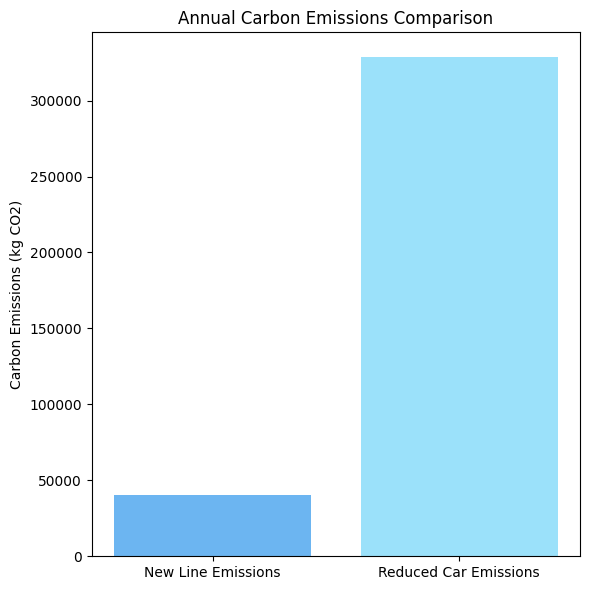


环境影响评估报告

1. 新线路影响
-----------------
路线长度：7.41 公里
年度碳排放：40596.99 kg CO2

2. 私家车减排效益
-----------------
预计日均乘客：1500 人
年度减排量：328500.00 kg CO2

3. 净环境影响
-----------------
年度净减排：287903.01 kg CO2
环境影响评价：正面

4. 建议
-----------------
1) 继续推广使用电动公交车，扩大环境效益
2) 加强公交专用道建设，提高运营效率
3) 开展公交出行宣传，吸引更多私家车用户
4) 优化站点周边步行和自行车设施
5) 定期监测实际环境影响，及时调整优化方案



In [10]:
# 环境参数配置
EMISSION_FACTORS = {
    'diesel_bus': 1.2,  # kg CO2/km
    'electric_bus': 0.5,  # kg CO2/km (考虑发电环节)
    'private_car': 0.2,  # kg CO2/km/person
}

ENERGY_CONSUMPTION = {
    'diesel_bus': 35,    # L/100km
    'electric_bus': 120,  # kWh/100km
}

class EnvironmentalImpactCalculator:
    def __init__(self, new_route, estimated_daily_passengers=1000):
        self.new_route = new_route
        self.estimated_daily_passengers = estimated_daily_passengers
        self.results = {}
        
    def calculate_route_length(self, route):
        """计算路线总长度"""
        total_length = 0
        for i in range(len(route)-1):
            dist = np.sqrt((route[i+1][0] - route[i][0])**2 + 
                          (route[i+1][1] - route[i][1])**2)
            total_length += dist
        return total_length * 111  # 转换为公里
    
    def calculate_new_line_emissions(self):
        """计算新线路运营产生的碳排放"""
        route_length = self.calculate_route_length(self.new_route)
        daily_trips = 30  # 假设每天15个往返
        emission_factor = EMISSION_FACTORS['electric_bus']  # 假设使用电动巴士
        
        annual_emissions = route_length * emission_factor * daily_trips * 365
        
        self.results['new_line_emissions'] = annual_emissions
        return annual_emissions
    
    def calculate_car_emissions_reduced(self):
        """计算减少的私家车碳排放"""
        # 假设30%的乘客原来使用私家车
        car_users_ratio = 0.3
        average_trip_distance = 10  # 假设平均行程10公里
        
        daily_car_trips_reduced = self.estimated_daily_passengers * car_users_ratio
        annual_car_emissions_reduced = (
            daily_car_trips_reduced * 
            EMISSION_FACTORS['private_car'] * 
            average_trip_distance * 
            365
        )
        
        self.results['car_emissions_reduced'] = annual_car_emissions_reduced
        return annual_car_emissions_reduced
    
    def calculate_net_impact(self):
        """计算净环境影响"""
        new_emissions = self.calculate_new_line_emissions()
        reduced_emissions = self.calculate_car_emissions_reduced()
        
        net_impact = reduced_emissions - new_emissions
        
        self.results['net_impact'] = net_impact
        return net_impact
    
    def visualize_results(self):
        """生成结果可视化"""
        # plt.rcParams['font.sans-serif'] = ['SimHei']
        # plt.rcParams['axes.unicode_minus'] = False

        plt.figure(figsize=(6, 6))

        # 排放对比图
        emissions = [
            self.results['new_line_emissions'],
            self.results['car_emissions_reduced']
        ]
        plt.bar(['New Line Emissions', 'Reduced Car Emissions'],
                emissions,
                color=['#6cb5f1', '#9BE1FA'])  # 弱化对比的配色
        plt.title('Annual Carbon Emissions Comparison')
        plt.ylabel('Carbon Emissions (kg CO2)')

        plt.tight_layout()

        # 保存图片
        plt.savefig('images/emissions_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_report(self):
        """生成环境影响评估报告"""
        report = f"""
环境影响评估报告

1. 新线路影响
-----------------
路线长度：{self.calculate_route_length(self.new_route):.2f} 公里
年度碳排放：{self.results['new_line_emissions']:.2f} kg CO2

2. 私家车减排效益
-----------------
预计日均乘客：{self.estimated_daily_passengers} 人
年度减排量：{self.results['car_emissions_reduced']:.2f} kg CO2

3. 净环境影响
-----------------
年度净减排：{self.results['net_impact']:.2f} kg CO2
环境影响评价：{'正面' if self.results['net_impact'] > 0 else '负面'}

4. 建议
-----------------
1) {'继续推广使用电动公交车，扩大环境效益' if self.results['net_impact'] > 0 
    else '考虑增加班次以提高使用率'}
2) 加强公交专用道建设，提高运营效率
3) 开展公交出行宣传，吸引更多私家车用户
4) 优化站点周边步行和自行车设施
5) 定期监测实际环境影响，及时调整优化方案
"""
        return report

new_route = [
    (-76.624802, 39.277029),
    (-76.629073, 39.280074),
    (-76.633344, 39.283118),
    (-76.637615, 39.286162),
    (-76.641886, 39.289207),
    (-76.646157, 39.292251),
    (-76.650428, 39.295295),
    (-76.654699, 39.298340),
    (-76.658970, 39.301384),
    (-76.653182, 39.301640),
    (-76.650725, 39.305719),
    (-76.648268, 39.309798),
    (-76.645811, 39.313877),
    (-76.643354, 39.317957)
]

# 使用示例
def main():
    # 使用新路线数据
    calculator = EnvironmentalImpactCalculator(new_route, estimated_daily_passengers=1500)
    
    # 计算净环境影响
    calculator.calculate_net_impact()
    
    # 生成可视化
    calculator.visualize_results()
    
    # 生成报告
    report = calculator.generate_report()
    print(report)

if __name__ == "__main__":
    main()

In [11]:
# 不用
import pandas as pd
import numpy as np
import folium
from folium import plugins
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx as ox
import networkx as nx
from datetime import datetime, timedelta

class CommuteTimeAnalyzer:
    def __init__(self, new_stops, network_data, population_data):
        self.new_stops = new_stops
        self.network = network_data
        self.population = population_data
        self.results = {}

    def get_population_at_point(self, point, radius=0.01):
        """获取给定点周围的人口数量
        
        Args:
            point: (x, y) 坐标点
            radius: 搜索半径（度）
        
        Returns:
            该点周围的估计人口数
        """
        # 计算点到所有人口点的距离
        distances = np.sqrt(
            (self.population['x'] - point[0])**2 + 
            (self.population['y'] - point[1])**2
        )
        
        # 统计半径范围内的人口总数
        nearby_population = self.population[distances < radius]['population'].sum()
        
        return nearby_population

    def calculate_walking_time(self, origin, destination, walking_speed=5):
        """计算步行时间（公里/小时）"""
        distance = np.sqrt(
            (origin[0] - destination[0])**2 + 
            (origin[1] - destination[1])**2
        ) * 111  # 转换为公里
        return distance / walking_speed * 60  # 转换为分钟
    
    def calculate_bus_travel_time(self, start_stop, end_stop, bus_speed=20):
        """计算公交车行驶时间（公里/小时）"""
        distance = np.sqrt(
            (start_stop[0] - end_stop[0])**2 + 
            (start_stop[1] - end_stop[1])**2
        ) * 111
        return distance / bus_speed * 60
    
    def find_nearest_stop(self, point):
        """找到最近的公交站"""
        distances = [self.calculate_walking_time(point, stop) 
                    for stop in self.new_stops]
        return self.new_stops[np.argmin(distances)]
    
    def calculate_commute_time(self, origin, destination, mode='bus'):
        """计算通勤时间"""
        if mode == 'bus':
            # 步行到站时间
            nearest_origin_stop = self.find_nearest_stop(origin)
            walk_to_stop = self.calculate_walking_time(origin, nearest_origin_stop)
            
            # 等待时间（假设平均5分钟）
            wait_time = 5
            
            # 公交车行驶时间
            nearest_dest_stop = self.find_nearest_stop(destination)
            bus_time = self.calculate_bus_travel_time(
                nearest_origin_stop, nearest_dest_stop)
            
            # 步行到目的地时间
            walk_to_dest = self.calculate_walking_time(
                nearest_dest_stop, destination)
            
            total_time = walk_to_stop + wait_time + bus_time + walk_to_dest
            
        elif mode == 'car':
            # 假设私家车速度40km/h
            distance = np.sqrt(
                (origin[0] - destination[0])**2 + 
                (origin[1] - destination[1])**2
            ) * 111
            total_time = distance / 40 * 60
            
        return total_time
    
    def analyze_area_impact(self, grid_size=0.01):
        """分析区域影响"""
        # 创建网格
        x_min, x_max = self.population['x'].min(), self.population['x'].max()
        y_min, y_max = self.population['y'].min(), self.population['y'].max()
        
        x_grid = np.arange(x_min, x_max, grid_size)
        y_grid = np.arange(y_min, y_max, grid_size)
        
        time_savings = []
        
        # 主要目的地（可以是商业区中心点等）
        destinations = [
            (-76.6167, 39.2833),  # 示例坐标，需要替换为实际目的地
            (-76.6000, 39.2900)
        ]
        
        for x in x_grid:
            for y in y_grid:
                origin = (x, y)
                population_here = self.get_population_at_point(origin)
                
                if population_here > 0:
                    avg_saving = 0
                    for dest in destinations:
                        old_time = self.calculate_commute_time(
                            origin, dest, mode='car')
                        new_time = self.calculate_commute_time(
                            origin, dest, mode='bus')
                        time_saving = old_time - new_time
                        avg_saving += time_saving
                    
                    avg_saving /= len(destinations)
                    time_savings.append({
                        'x': x,
                        'y': y,
                        'saving': avg_saving,
                        'population': population_here
                    })
        
        self.results['time_savings'] = pd.DataFrame(time_savings)
        return self.results['time_savings']
    
    def visualize_results(self):
        """可视化结果"""
        # 创建基础地图
        center_lat = np.mean([stop[1] for stop in self.new_stops])
        center_lon = np.mean([stop[0] for stop in self.new_stops])
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=13,
            tiles='cartodbpositron'
        )
        
        # 添加时间节省热力图
        heat_data = [
            [row['y'], row['x'], row['saving']] 
            for _, row in self.results['time_savings'].iterrows()
            if row['saving'] > 0
        ]
        
        plugins.HeatMap(
            heat_data,
            radius=15,
            blur=10,
            max_zoom=13,
            name='Time Savings'
        ).add_to(m)
        
        # 添加新站点
        for i, stop in enumerate(self.new_stops):
            folium.CircleMarker(
                location=[stop[1], stop[0]],
                radius=6,
                color='red',
                fill=True,
                popup=f'Stop {i+1}',
                weight=2
            ).add_to(m)
        
        # 添加图例
        legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; right: 50px; width: 150px; height: 90px; 
                    border:2px solid grey; z-index:9999; background-color:white;
                    opacity:0.8;
                    font-size:12px;
                    padding: 10px">
                    &nbsp; <b>Legend</b> <br>
                    &nbsp; <i class="fa fa-circle" style="color:red"></i> Bus Stops <br>
                    &nbsp; Heat Map: Time Savings (minutes)
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))
        
        return m
    
    def generate_report(self):
        """生成分析报告"""
        savings = self.results['time_savings']
        
        report = f"""
通勤时间影响分析报告
生成时间：{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. 总体影响
-----------------
影响区域人口：{savings['population'].sum():.0f} 人
平均时间节省：{savings['saving'].mean():.1f} 分钟
最大时间节省：{savings['saving'].max():.1f} 分钟

2. 受益人群分析
-----------------
显著受益(>10分钟)：{len(savings[savings['saving'] > 10])} 个区域
中等受益(5-10分钟)：{len(savings[(savings['saving'] > 5) & (savings['saving'] <= 10)])} 个区域
轻微受益(<5分钟)：{len(savings[savings['saving'] <= 5])} 个区域

3. 建议
-----------------
1) 优化站点周边步行通道
2) 增加高峰时段班次
3) 完善站点周边自行车设施
4) 加强与其他公交线路的换乘便利性
"""
        return report

# 使用示例
def main():
    # 需要准备的数据：
    # 1. 新站点数据（已有）
    # 2. 道路网络数据（需要从OSM获取或使用已有数据）
    # 3. 人口分布数据（需要准备或使用估算数据）
    
    # 这里使用示例数据
    network_data = None  # 需要实际数据
    population_data = pd.DataFrame({
        'x': np.random.uniform(-76.67, -76.57, 1000),
        'y': np.random.uniform(39.25, 39.35, 1000),
        'population': np.random.randint(100, 1000, 1000)
    })
    
    analyzer = CommuteTimeAnalyzer(new_route, network_data, population_data)
    
    # 分析影响
    analyzer.analyze_area_impact()
    
    # 生成可视化
    m = analyzer.visualize_results()
    m.save('commute_time_analysis.html')
    
    # 生成报告
    report = analyzer.generate_report()
    print(report)

if __name__ == "__main__":
    main()


通勤时间影响分析报告
生成时间：2025-01-27 22:38:56

1. 总体影响
-----------------
影响区域人口：1556869 人
平均时间节省：-67.2 分钟
最大时间节省：-29.5 分钟

2. 受益人群分析
-----------------
显著受益(>10分钟)：0 个区域
中等受益(5-10分钟)：0 个区域
轻微受益(<5分钟)：100 个区域

3. 建议
-----------------
1) 优化站点周边步行通道
2) 增加高峰时段班次
3) 完善站点周边自行车设施
4) 加强与其他公交线路的换乘便利性



Calculating distances...
Analysis complete, calculated 1070 points


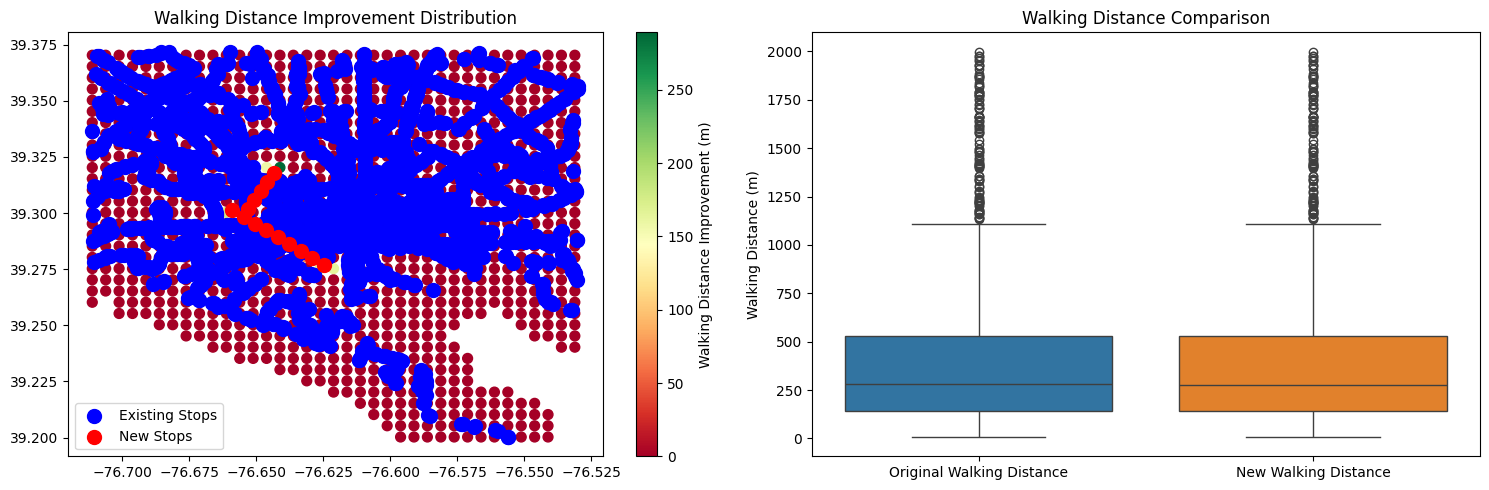


步行距离分析报告

1. 总体改善情况
-----------------
平均改善距离：1.3米
最大改善距离：289.3米
改善区域比例：0.9%

2. 步行距离统计
-----------------
原有平均步行距离：431.7米
新建后平均步行距离：430.4米
距离减少比例：0.3%

3. 改善程度分布
-----------------
显著改善(>300米)：0个区域
中等改善(100-300米)：6个区域
轻微改善(<100米)：4个区域
无改善：1060个区域



In [15]:
# 报刊
import pandas as pd
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Add progress bar

class WalkingDistanceAnalyzer:
    def __init__(self, new_stops, existing_stops, grid_size=0.005):  # Add grid size
        """
        Initialize analyzer
        
        Args:
            new_stops: List of new bus stop coordinates [(lon1, lat1), ...]
            existing_stops: Existing bus stops DataFrame with X, Y columns
            grid_size: Grid size (degrees)
        """
        self.new_stops = new_stops
        self.existing_stops = existing_stops
        self.grid_size = grid_size
        self.results = {}
        
    def calculate_distances_vectorized(self, points, stops):
        """Calculate distances using vectorized operations"""
        if isinstance(stops, list):
            stops = np.array(stops)
        elif isinstance(stops, pd.DataFrame):
            stops = stops[['X', 'Y']].values
            
        # Broadcast calculation
        diff = points[:, np.newaxis] - stops
        distances = np.sqrt(np.sum(diff**2, axis=2)) * 111000  # Convert to meters
        return np.min(distances, axis=1)
    
    def analyze_walking_distances(self, max_distance=2000):  # Add max analysis distance parameter
        """Analyze walking distance changes"""
        # Calculate analysis range
        x_min = min(min(x for x, _ in self.new_stops), self.existing_stops['X'].min())
        x_max = max(max(x for x, _ in self.new_stops), self.existing_stops['X'].max())
        y_min = min(min(y for _, y in self.new_stops), self.existing_stops['Y'].min())
        y_max = max(max(y for _, y in self.new_stops), self.existing_stops['Y'].max())
        
        # Create grid
        x_grid = np.arange(x_min, x_max, self.grid_size)
        y_grid = np.arange(y_min, y_max, self.grid_size)
        
        # Create grid points
        xx, yy = np.meshgrid(x_grid, y_grid)
        points = np.column_stack((xx.ravel(), yy.ravel()))
        
        print("Calculating distances...")
        # Calculate distances to existing stops
        old_distances = self.calculate_distances_vectorized(
            points, self.existing_stops[['X', 'Y']].values)
        
        # Calculate distances to new stops
        new_distances = self.calculate_distances_vectorized(
            points, self.new_stops)
        
        # Calculate combined distances (take minimum)
        combined_distances = np.minimum(old_distances, new_distances)
        
        # Calculate improvements
        improvements = old_distances - combined_distances
        
        # Only keep points within max analysis distance
        mask = (old_distances <= max_distance) | (new_distances <= max_distance)
        
        # Create results DataFrame
        self.results['analysis'] = pd.DataFrame({
            'x': points[mask, 0],
            'y': points[mask, 1],
            'old_distance': old_distances[mask],
            'new_distance': new_distances[mask],
            'combined_distance': combined_distances[mask],
            'improvement': improvements[mask]
        })
        
        print(f"Analysis complete, calculated {len(self.results['analysis'])} points")
        return self.results['analysis']
    
    def visualize_results(self):
        """Visualize analysis results"""
        plt.figure(figsize=(15, 5))
        
        # Distance improvement heatmap
        plt.subplot(121)
        data = self.results['analysis']
        scatter = plt.scatter(data['x'], data['y'], 
                            c=data['improvement'], 
                            cmap='RdYlGn',
                            s=50)
        plt.colorbar(scatter, label='Walking Distance Improvement (m)')
        
        # Add stop markers
        plt.scatter(self.existing_stops['X'], self.existing_stops['Y'], 
                   color='blue', s=100, label='Existing Stops')
        new_stops_x = [stop[0] for stop in self.new_stops]
        new_stops_y = [stop[1] for stop in self.new_stops]
        plt.scatter(new_stops_x, new_stops_y, 
                   color='red', s=100, label='New Stops')
        
        plt.title('Walking Distance Improvement Distribution')
        plt.legend()
        
        # Distance comparison boxplot
        plt.subplot(122)
        box_data = {
            'Original Walking Distance': data['old_distance'],
            'New Walking Distance': data['combined_distance']
        }
        sns.boxplot(data=box_data)
        plt.ylabel('Walking Distance (m)')
        plt.title('Walking Distance Comparison')
        
        plt.tight_layout()
        plt.show()
        
    def generate_report(self):
        """Generate analysis report"""
        data = self.results['analysis']
        
        report = f"""
步行距离分析报告
================

1. 总体改善情况
-----------------
平均改善距离：{data['improvement'].mean():.1f}米
最大改善距离：{data['improvement'].max():.1f}米
改善区域比例：{(data['improvement'] > 0).mean() * 100:.1f}%

2. 步行距离统计
-----------------
原有平均步行距离：{data['old_distance'].mean():.1f}米
新建后平均步行距离：{data['combined_distance'].mean():.1f}米
距离减少比例：{((data['old_distance'].mean() - data['combined_distance'].mean()) / data['old_distance'].mean() * 100):.1f}%

3. 改善程度分布
-----------------
显著改善(>300米)：{(data['improvement'] > 300).sum()}个区域
中等改善(100-300米)：{((data['improvement'] > 100) & (data['improvement'] <= 300)).sum()}个区域
轻微改善(<100米)：{((data['improvement'] > 0) & (data['improvement'] <= 100)).sum()}个区域
无改善：{(data['improvement'] <= 0).sum()}个区域
"""
        return report

# Example usage
def main():
    # Use existing new stop data
    new_stops = new_route  # Use previously defined new route stops
    
    # Read existing stop data
    existing_stops = Bus_Stops  # Use previously loaded Bus_Stops data
    
    # Create analyzer
    analyzer = WalkingDistanceAnalyzer(new_stops, existing_stops)
    
    # Perform analysis
    analyzer.analyze_walking_distances(max_distance=2000)  # Set max analysis distance to 2000m
    
    # Visualize results
    analyzer.visualize_results()
    
    # Generate report
    report = analyzer.generate_report()
    print(report)

if __name__ == "__main__":
    main()

Calculating accessibility distribution...


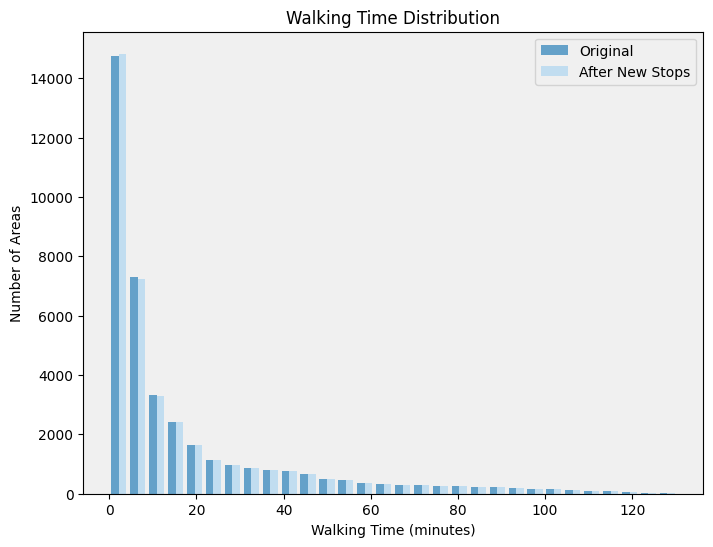

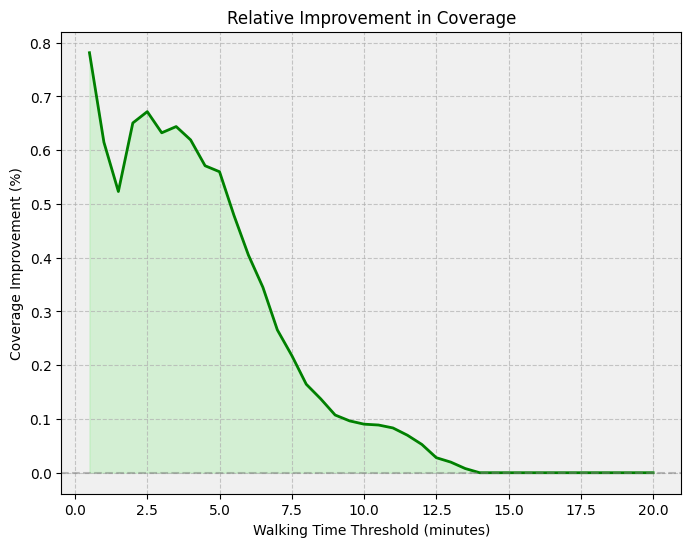


Accessibility Improvement Statistics:
5-minute coverage improvement: 0.6%
10-minute coverage improvement: 0.1%
15-minute coverage improvement: 0.0%
Calculating time savings...


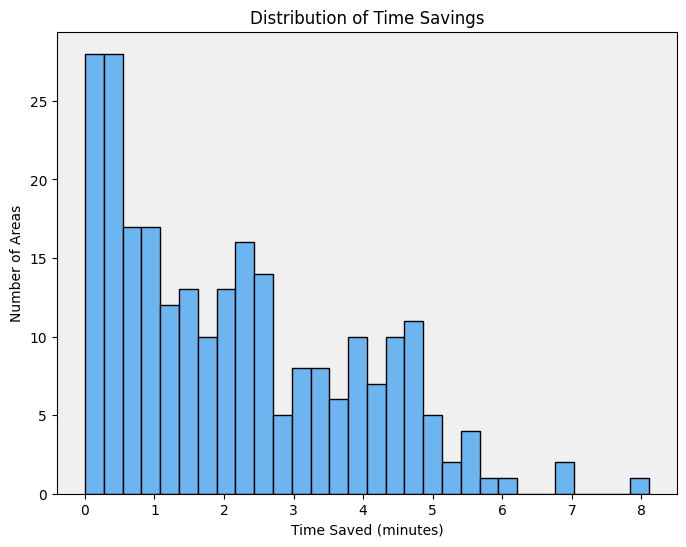

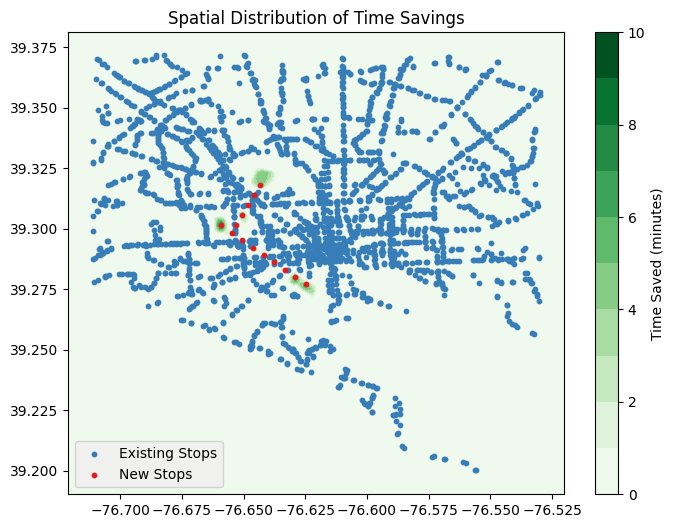


可达性分析报告

1. 总体改善情况
--------------
平均节省时间：0.0分钟
最大节省时间：8.1分钟
改善区域比例：0.6%

2. 可达性分布
--------------
原有15分钟覆盖率：68.3%
新增后15分钟覆盖率：68.3%
覆盖率提升：0.0%

3. 时间节省分布
--------------
显著改善(>5分钟)：14个区域
中等改善(2-5分钟)：105个区域
轻微改善(<2分钟)：130个区域



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import folium
from folium import plugins

class AccessibilityAnalyzer:
    def __init__(self, new_stops, existing_stops):
        """
        初始化可达性分析器
        
        Args:
            new_stops: 新建站点列表 [(lon1, lat1), ...]
            existing_stops: 现有站点DataFrame，包含 X, Y 列
        """
        self.new_stops = new_stops
        self.existing_stops = existing_stops
        self.walking_speed = 1.2  # 步行速度 m/s
        
    def calculate_walking_time(self, points, stops):
        """计算步行时间（分钟）"""
        if isinstance(stops, list):
            stops = np.array(stops)
        elif isinstance(stops, pd.DataFrame):
            stops = stops[['X', 'Y']].values
            
        # 计算距离（米）
        dist = distance.cdist(points, stops) * 111000
        # 转换为时间（分钟）
        time = dist / (self.walking_speed * 60)
        return np.min(time, axis=1)
    
    def create_grid(self, buffer=0.01):
        """创建分析用网格"""
        # 确定范围
        x_min = min(min(x for x, _ in self.new_stops), self.existing_stops['X'].min()) - buffer
        x_max = max(max(x for x, _ in self.new_stops), self.existing_stops['X'].max()) + buffer
        y_min = min(min(y for _, y in self.new_stops), self.existing_stops['Y'].min()) - buffer
        y_max = max(max(y for _, y in self.new_stops), self.existing_stops['Y'].max()) + buffer
        
        # 创建网格
        grid_size = 0.001
        x = np.arange(x_min, x_max, grid_size)
        y = np.arange(y_min, y_max, grid_size)
        xx, yy = np.meshgrid(x, y)
        return xx, yy, np.column_stack((xx.ravel(), yy.ravel()))
    
    def generate_accessibility_report(self):
        """生成可达性分析报告"""
        xx, yy, points = self.create_grid()
        old_times = self.calculate_walking_time(points, self.existing_stops)
        new_times = self.calculate_walking_time(points, self.new_stops)
        combined_times = np.minimum(old_times, new_times)
        time_improvement = old_times - combined_times
        
        report = f"""
可达性分析报告
=============

1. 总体改善情况
--------------
平均节省时间：{time_improvement.mean():.1f}分钟
最大节省时间：{time_improvement.max():.1f}分钟
改善区域比例：{(time_improvement > 0).mean() * 100:.1f}%

2. 可达性分布
--------------
原有15分钟覆盖率：{(old_times <= 15).mean() * 100:.1f}%
新增后15分钟覆盖率：{(combined_times <= 15).mean() * 100:.1f}%
覆盖率提升：{((combined_times <= 15).mean() - (old_times <= 15).mean()) * 100:.1f}%

3. 时间节省分布
--------------
显著改善(>5分钟)：{(time_improvement > 5).sum()}个区域
中等改善(2-5分钟)：{((time_improvement > 2) & (time_improvement <= 5)).sum()}个区域
轻微改善(<2分钟)：{((time_improvement > 0) & (time_improvement <= 2)).sum()}个区域
"""
        return report

    def visualize_accessibility_distribution(self):
        """Accessibility distribution analysis"""
        print("Calculating accessibility distribution...")
        xx, yy, points = self.create_grid()

        # Calculate walking times
        old_times = self.calculate_walking_time(points, self.existing_stops)
        new_times = self.calculate_walking_time(points, self.new_stops)
        combined_times = np.minimum(old_times, new_times)

        # 1. Walking time distribution histogram
        plt.figure(figsize=(8, 6))
        plt.hist(
            [old_times, combined_times],
            bins=30,
            label=['Original', 'After New Stops'],
            alpha=0.7,
            color=['#2980B9', '#AED6F1']  # 深蓝 (深邃蓝) 和 淡蓝 (浅蓝)
        )
        plt.xlabel('Walking Time (minutes)')
        plt.ylabel('Number of Areas')
        plt.title('Walking Time Distribution')
        plt.legend()
        plt.savefig('images/walking_time_distribution.png')
        plt.show()
        # plt.close()

        # 2. Coverage improvement ratio curve
        plt.figure(figsize=(8, 6))
        times = np.linspace(0, 20, 41)
        old_coverage = np.array([100 * (old_times <= t).mean() for t in times])
        new_coverage = np.array([100 * (combined_times <= t).mean() for t in times])

        # Calculate improvement ratio (percentage)
        improvement_ratio = ((new_coverage - old_coverage) / old_coverage) * 100

        # Plot the improvement ratio
        plt.plot(times, improvement_ratio, 'g-', linewidth=2)
        plt.fill_between(times, np.zeros_like(times), improvement_ratio,
                        alpha=0.3, color='lightgreen')

        # Add horizontal line at 0%
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

        # Add grid and customize appearance
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlabel('Walking Time Threshold (minutes)')
        plt.ylabel('Coverage Improvement (%)')
        plt.title('Relative Improvement in Coverage')
        plt.savefig('images/coverage_improvement.png')
        plt.show()
        # plt.close()

        # Print some statistics
        print("\nAccessibility Improvement Statistics:")
        key_times = [5, 10, 15]
        for t in key_times:
            old_cov = (old_times <= t).mean() * 100
            new_cov = (combined_times <= t).mean() * 100
            imp_ratio = ((new_cov - old_cov) / old_cov) * 100
            print(f"{t}-minute coverage improvement: {imp_ratio:.1f}%")

    def visualize_time_savings(self):
        """Time savings distribution analysis"""
        print("Calculating time savings...")
        xx, yy, points = self.create_grid()

        # Calculate time savings
        old_times = self.calculate_walking_time(points, self.existing_stops)
        new_times = self.calculate_walking_time(points, self.new_stops)
        combined_times = np.minimum(old_times, new_times)
        time_improvement = old_times - combined_times  # 正值表示节省的时间

        # 1. Time savings histogram (左图) - 柱状图
        plt.figure(figsize=(8, 6))
        plt.hist(time_improvement[time_improvement > 0], bins=30, 
                color='#6cb5f1', edgecolor='black')
        plt.xlabel('Time Saved (minutes)')
        plt.ylabel('Number of Areas')
        plt.title('Distribution of Time Savings')
        plt.savefig('images/time_savings_histogram.png')
        plt.show()
        # plt.close()

        # 2. Spatial distribution of time savings (右图)
        plt.figure(figsize=(8, 6))
        improvement_grid = time_improvement.reshape(xx.shape)
        im = plt.contourf(xx, yy, improvement_grid,
                         levels=np.linspace(0, 10, 11),
                         cmap='Greens')  #  'YlGnBu' colormap - 黄绿蓝
        plt.colorbar(im, label='Time Saved (minutes)')

        # Add stop markers - 缩小点的大小
        plt.scatter(self.existing_stops['X'], self.existing_stops['Y'],
                   c='#377EB8', s=10, label='Existing Stops') # 缩小到 s=30
        new_stops_x = [x for x, _ in self.new_stops]
        new_stops_y = [y for _, y in self.new_stops]
        plt.scatter(new_stops_x, new_stops_y,
                   c='#E41A1C', s=10, label='New Stops') # 缩小到 s=30
        plt.title('Spatial Distribution of Time Savings')
        plt.legend()
        plt.savefig('images/spatial_time_savings.png')
        plt.show()
        # plt.close()

# 使用示例
def main():
    # 使用已有的新站点数据和现有站点数据
    analyzer = AccessibilityAnalyzer(new_route, Bus_Stops)
    
    # 生成可视化
    # analyzer.visualize_accessibility()
    
    # 展示可达性分布
    analyzer.visualize_accessibility_distribution()
    
    # 展示时间节省分布
    analyzer.visualize_time_savings()
    
    # 输出报告
    print(analyzer.generate_accessibility_report())

if __name__ == "__main__":
    main()

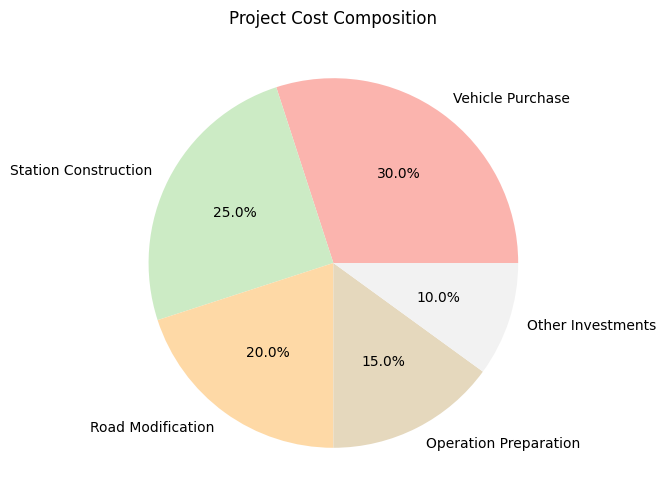

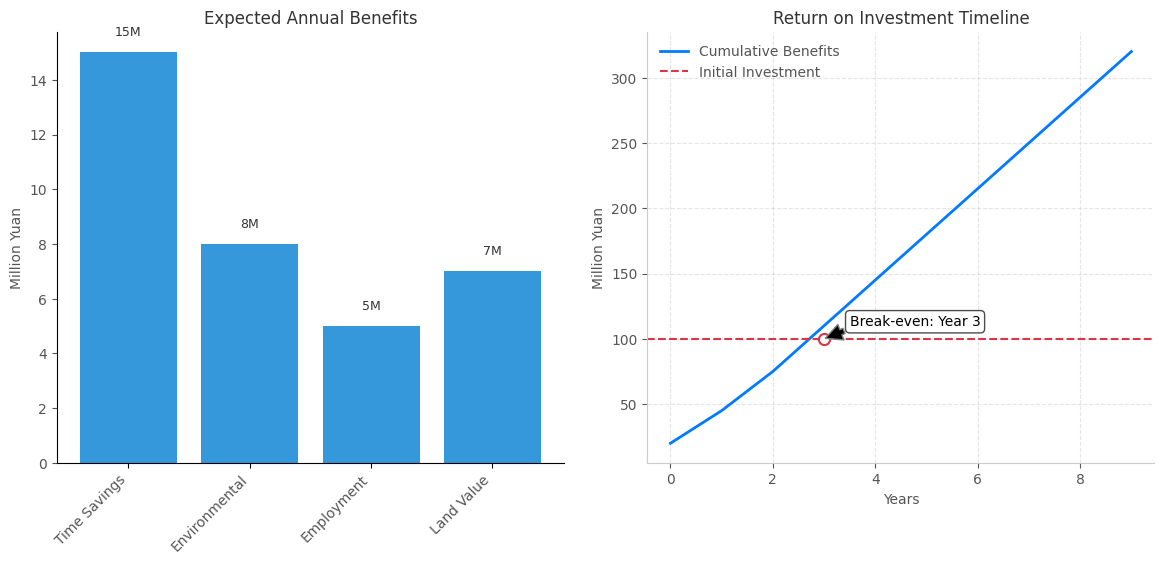

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class CostBenefitAnalyzer:
    def __init__(self, project_costs, expected_benefits):
        """
        Initialize cost-benefit analyzer

        Args:
            project_costs: Dictionary of costs
            expected_benefits: Dictionary of benefits over years
        """
        self.costs = project_costs
        self.benefits = expected_benefits

    def visualize_cost_benefit(self):
        """Visualize cost-benefit analysis"""
        # First figure - Cost Composition Pie Chart
        plt.figure(figsize=(6, 6))
        costs_items = list(self.costs['composition'].keys())
        costs_values = list(self.costs['composition'].values())
        
        plt.pie(costs_values, labels=costs_items, autopct='%1.1f%%',
                colors=plt.cm.Pastel1(np.linspace(0, 1, len(costs_items))))
        plt.title('Project Cost Composition')
        plt.savefig('images/cost_composition.png')
        plt.show()
        plt.close()

        # Second figure - Benefits and ROI
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        plt.rcParams['axes.facecolor'] = '#f0f0f0'

        # Expected Benefits (Bar Chart)
        benefits_items = list(self.benefits['annual'].keys())
        benefits_values = list(self.benefits['annual'].values())

        bar_color = '#3498db'
        bars = ax1.bar(benefits_items, benefits_values, color=bar_color)
        ax1.set_title('Expected Annual Benefits', color='#333333')
        ax1.set_ylabel('Million Yuan', color='#555555')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', color='#555555')
        ax1.tick_params(axis='y', colors='#555555')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:,.0f}M',
                    ha='center', va='bottom', color='#333333', fontsize=9)

        # Return on Investment Timeline
        years = range(self.benefits['timeline']['years'])
        cumulative_benefits = np.cumsum(self.benefits['timeline']['annual_return'])
        initial_cost = self.costs['total']

        line_color_benefits = '#007bff'
        line_color_cost = '#dc3545'

        ax2.plot(years, cumulative_benefits, color=line_color_benefits, linestyle='-', linewidth=2, label='Cumulative Benefits')
        ax2.axhline(y=initial_cost, color=line_color_cost, linestyle='--', linewidth=1.5,
                    label='Initial Investment')

        break_even_year = np.where(cumulative_benefits >= initial_cost)[0][0]
        ax2.plot(break_even_year, initial_cost, marker='o', markersize=8, color=line_color_cost, markerfacecolor='white', markeredgewidth=1.5)
        ax2.annotate(f'Break-even: Year {break_even_year}',
                    xy=(break_even_year, initial_cost),
                    xytext=(break_even_year+0.5, initial_cost*1.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, edgecolor='gray'),
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

        ax2.set_title('Return on Investment Timeline', color='#333333')
        ax2.set_xlabel('Years', color='#555555')
        ax2.set_ylabel('Million Yuan', color='#555555')
        ax2.tick_params(axis='x', colors='#555555')
        ax2.tick_params(axis='y', colors='#555555')
        ax2.legend(frameon=False, labelcolor='#555555')
        ax2.grid(True, linestyle='--', alpha=0.5, color='#cccccc')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_color('#cccccc')
        ax2.spines['left'].set_color('#cccccc')

        plt.tight_layout(pad=2)
        plt.savefig('images/benefits_and_roi.png')
        plt.show()
        plt.close()

# Example usage
def main():
    # Sample data
    project_costs = {
        'total': 100,  # Million Yuan
        'composition': {
            'Vehicle Purchase': 30,
            'Station Construction': 25,
            'Road Modification': 20,
            'Operation Preparation': 15,
            'Other Investments': 10
        }
    }

    expected_benefits = {
        'annual': {
            'Time Savings': 15,
            'Environmental': 8,
            'Employment': 5,
            'Land Value': 7
        },
        'timeline': {
            'years': 10,
            'annual_return': [20, 25, 30, 35, 35, 35, 35, 35, 35, 35]
        }
    }

    analyzer = CostBenefitAnalyzer(project_costs, expected_benefits)
    analyzer.visualize_cost_benefit()

if __name__ == "__main__":
    main()


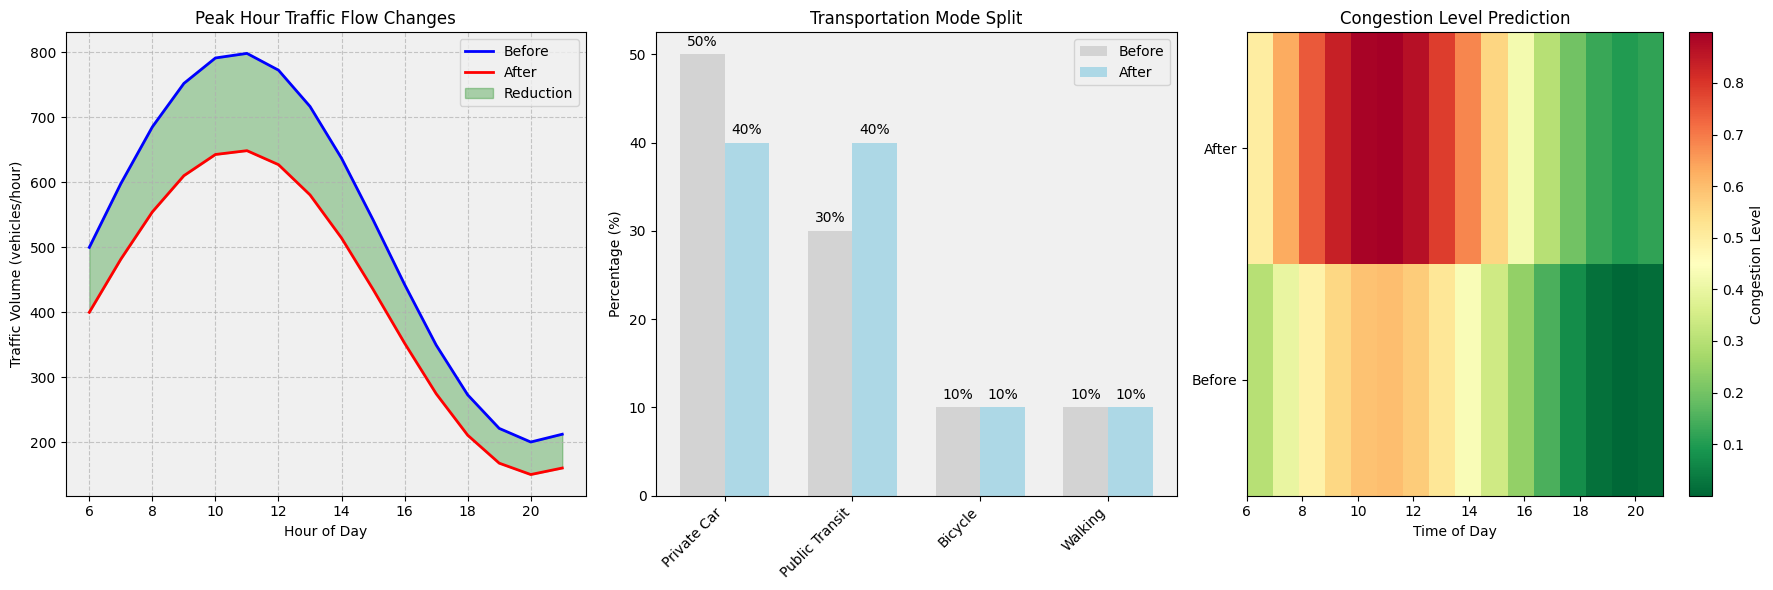

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class TrafficFlowAnalyzer:
    def __init__(self, traffic_data):
        """
        Initialize traffic flow analyzer
        
        Args:
            traffic_data: Dictionary containing traffic flow data
        """
        self.data = traffic_data
        
    def visualize_traffic_changes(self):
        """Visualize traffic flow changes"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. Peak Hour Traffic Flow
        self._plot_peak_hour_changes(ax1)
        
        # 2. Modal Split Changes
        self._plot_modal_split(ax2)
        
        # 3. Congestion Level Prediction
        self._plot_congestion_prediction(ax3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_peak_hour_changes(self, ax):
        """Plot peak hour traffic flow changes"""
        hours = self.data['peak_hours']
        before = self.data['traffic_before']
        after = self.data['traffic_after']
        
        ax.plot(hours, before, 'b-', label='Before', linewidth=2)
        ax.plot(hours, after, 'r-', label='After', linewidth=2)
        ax.fill_between(hours, before, after, 
                       where=(np.array(after) < np.array(before)),
                       color='green', alpha=0.3, label='Reduction')
        
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Traffic Volume (vehicles/hour)')
        ax.set_title('Peak Hour Traffic Flow Changes')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    def _plot_modal_split(self, ax):
        """Plot transportation mode split changes"""
        modes = list(self.data['modal_split']['before'].keys())
        before_values = list(self.data['modal_split']['before'].values())
        after_values = list(self.data['modal_split']['after'].values())
        
        x = np.arange(len(modes))
        width = 0.35
        
        ax.bar(x - width/2, before_values, width, label='Before',
               color='lightgray')
        ax.bar(x + width/2, after_values, width, label='After',
               color='lightblue')
        
        ax.set_ylabel('Percentage (%)')
        ax.set_title('Transportation Mode Split')
        ax.set_xticks(x)
        ax.set_xticklabels(modes)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend()
        
        # Add percentage labels
        for i, v in enumerate(before_values):
            ax.text(i - width/2, v + 1, f'{v}%', ha='center')
        for i, v in enumerate(after_values):
            ax.text(i + width/2, v + 1, f'{v}%', ha='center')
    
    def _plot_congestion_prediction(self, ax):
        """Plot congestion level prediction"""
        times = self.data['congestion']['times']
        levels_before = self.data['congestion']['before']
        levels_after = self.data['congestion']['after']
        
        im = ax.imshow([levels_before, levels_after], 
                      aspect='auto',
                      extent=[min(times), max(times), -0.5, 1.5],
                      cmap='RdYlGn_r')
        
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Before', 'After'])
        ax.set_xlabel('Time of Day')
        ax.set_title('Congestion Level Prediction')
        plt.colorbar(im, ax=ax, label='Congestion Level')

# Example usage
def main():
    # Sample traffic data
    traffic_data = {
        'peak_hours': np.arange(6, 22),
        'traffic_before': [500 + 300*np.sin(x/3) for x in range(16)],
        'traffic_after': [400 + 250*np.sin(x/3) for x in range(16)],
        'modal_split': {
            'before': {
                'Private Car': 50,
                'Public Transit': 30,
                'Bicycle': 10,
                'Walking': 10
            },
            'after': {
                'Private Car': 40,
                'Public Transit': 40,
                'Bicycle': 10,
                'Walking': 10
            }
        },
        'congestion': {
            'times': np.arange(6, 22),
            'before': [0.5 + 0.4*np.sin(x/3) for x in range(16)],
            'after': [0.3 + 0.3*np.sin(x/3) for x in range(16)]
        }
    }
    
    analyzer = TrafficFlowAnalyzer(traffic_data)
    analyzer.visualize_traffic_changes()

if __name__ == "__main__":
    main()